# DATA PREPROCESSING

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [3]:
# Load Data
df = pd.read_csv(r'C:\Users\albyp\Downloads\bank-full.csv', sep=';')

# Dataset info
print(df.head())
df.info()
print(df.isnull().sum())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #

### **Input Variables**

- **age**
  - **Description**: The age of the client, measured in years. This is a numeric variable and is important for assessing the likelihood of subscribing to a term deposit, as older clients may have different financial behaviors.

- **job**
  - **Description**: The type of job held by the client. This is a categorical variable with the following values:
    - "admin.": Administrative job
    - "blue-collar": Factory or manual labor job
    - "entrepreneur": Self-employed business owner
    - "housemaid": Domestic worker
    - "management": Managerial position
    - "retired": Retired from work
    - "self-employed": Owns or runs their own business
    - "services": Works in the service industry (e.g., sales, healthcare)
    - "student": A full-time student
    - "technician": Technical or engineering role
    - "unemployed": Currently out of work
    - "unknown": Job type is not provided

- **marital_status**
  - **Description**: The marital status of the client. This is a categorical variable with the following values:
    - "married": Married individuals
    - "divorced": Separated or widowed individuals
    - "single": Unmarried individuals

- **education**
  - **Description**: The highest level of education attained by the client. This is a categorical variable with the following values:
    - "unknown": Education level is not provided
    - "secondary": Completed secondary school (high school)
    - "primary": Completed primary school
    - "tertiary": Completed higher education (e.g., university, college)

- **default**
  - **Description**: Indicates whether the client has any credit in default. This is a binary variable with the following values:
    - "yes": Client has credit in default
    - "no": Client does not have credit in default

- **balance**
  - **Description**: The average yearly balance (in euros) of the client’s bank account. This is a numeric variable, reflecting the financial standing of the client.

- **housing**
  - **Description**: Indicates whether the client has a housing loan. This is a binary variable with the following values:
    - "yes": Client has a housing loan
    - "no": Client does not have a housing loan

- **loan**
  - **Description**: Indicates whether the client has a personal loan. This is a binary variable with the following values:
    - "yes": Client has a personal loan
    - "no": Client does not have a personal loan

- **contact**
  - **Description**: The type of communication used to contact the client. This is a categorical variable with the following values:
    - "unknown": The type of communication is unknown
    - "telephone": Contacted via telephone
    - "cellular": Contacted via cellular phone

- **day**
  - **Description**: The day of the last contact with the client, represented as a numeric value (1 to 31). This variable may help assess whether the timing of the contact affects the likelihood of subscribing to a term deposit.

- **month**
  - **Description**: The month of the last contact with the client. This is a categorical variable with the following values:
    - "jan", "feb", "mar", ..., "dec": The month in which the last contact was made.

- **duration**
  - **Description**: The duration of the last contact with the client, measured in seconds. This is a numeric variable and can be an important factor in understanding whether longer conversations lead to higher subscription rates.

- **campaign**
  - **Description**: The number of contacts performed during the current campaign for this client (including the last contact). This is a numeric variable, and it helps understand how persistent the campaign was with the client.

- **pdays**
  - **Description**: The number of days that passed since the client was last contacted from a previous campaign. This is a numeric variable, where a value of -1 means the client was not contacted previously.

- **previous**
  - **Description**: The number of contacts performed before this campaign for this client. This numeric variable shows the client’s previous interaction history, which may influence the likelihood of conversion.

- **poutcome**
  - **Description**: The outcome of the previous marketing campaign. This is a categorical variable with the following values:
    - "unknown": Outcome of the previous campaign is unknown
    - "other": The outcome was something other than success or failure
    - "failure": Previous campaign failed
    - "success": Previous campaign was successful
  
---

### **Output Variable (Target)**

- **y**
  - **Description**: The target variable that indicates whether the client subscribed to a term deposit. This is a binary variable:
    - "yes": The client subscribed to a term deposit
    - "no": The client did not subscribe to a term deposit
(binary: "yes", "no").
binario: "yes", "no").
 (binary: "yes","no")



We remove duration and campaign since not realistic for our task (it is known after the call).

In [4]:
df = df.drop(columns=['duration','campaign'])

## DATA VISUALIZATION

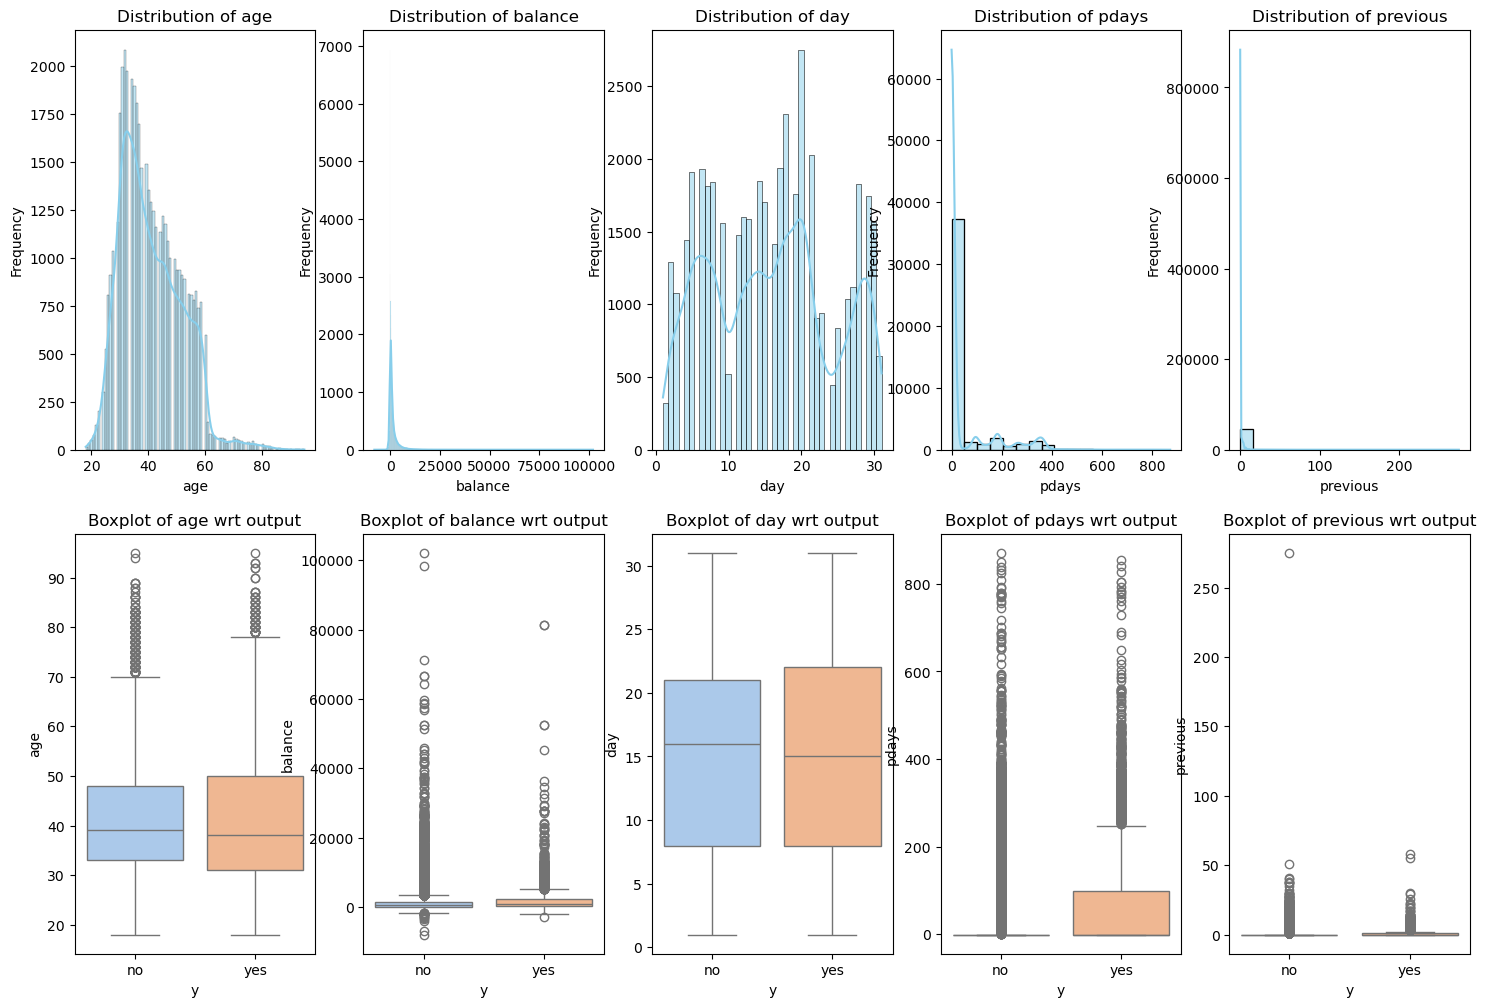

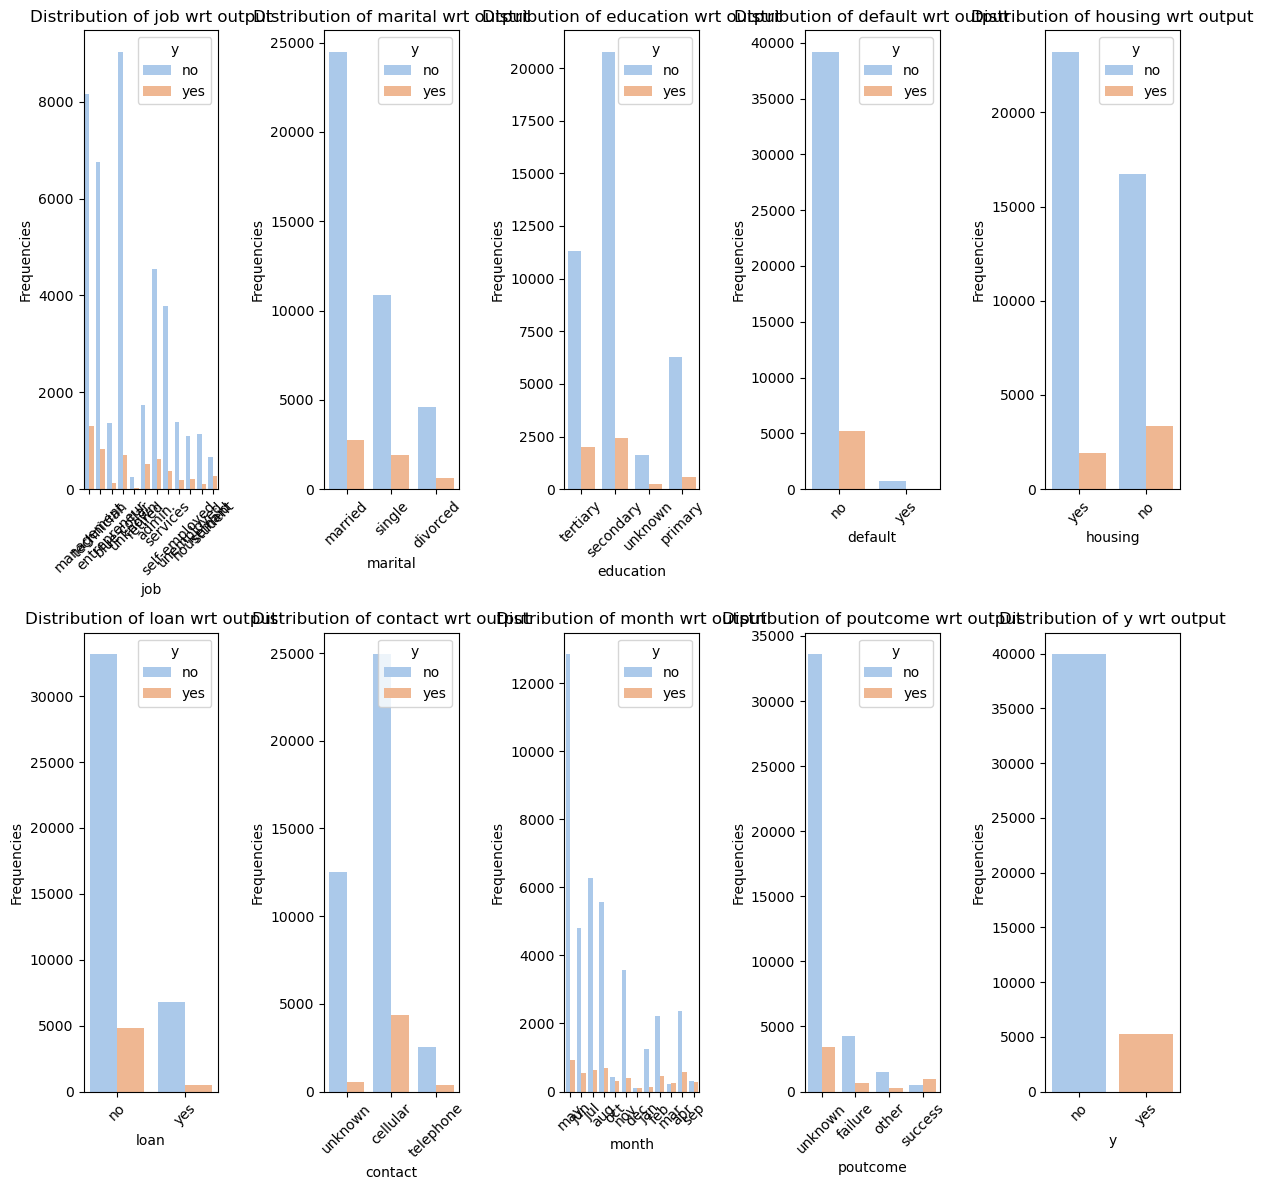

In [8]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Create a 2x5 grid for the plots (left for distribution, right for boxplots)
fig, axes = plt.subplots(2, 5, figsize=(18, 12))  # 2 rows, 5 columns
axes = axes.ravel()

# Plot distribution for numerical variables on the left
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Plot boxplot for numerical variables with respect to target on the right
for i, col in enumerate(num_cols):
    sns.boxplot(x=df['y'], y=df[col], palette='pastel', ax=axes[i + len(num_cols)], hue=df['y'], legend=False)
    axes[i + len(num_cols)].set_title(f"Boxplot of {col} wrt output")
    axes[i + len(num_cols)].set_xlabel("y")
    axes[i + len(num_cols)].set_ylabel(col)

# Frequencies for each categorical variable wrt target
fig, axes = plt.subplots(2, 5, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], hue=df['y'], palette='pastel', ax=axes[i])
    axes[i].set_title(f"Distribution of {col} wrt output")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequencies")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We proceed in feature selection and handling missing values.

We remove contact, day and month since uninformative features. We then modify the job variable in: student, employed, unemployed and retired. Lastly, we will consider only people called in previous campaigns (hence poutcome = failure or success). For missing values we consider the unknown classes.

In [9]:
# Remove missing values
df = df[(df['education'] != 'unknown') & (df['job'] != 'unknown')]

# Removing features
features_to_remove = ['marital', 'month', 'day', 'contact'] 
df = df.drop(columns=features_to_remove)

# Modifying job feature
df.loc[~df['job'].isin(['student', 'unemployed', 'retired']), 'job'] = 'employed'

# Keep only previously called people
df = df[df['poutcome'].isin(['failure', 'success'])]

df.shape

(6133, 11)

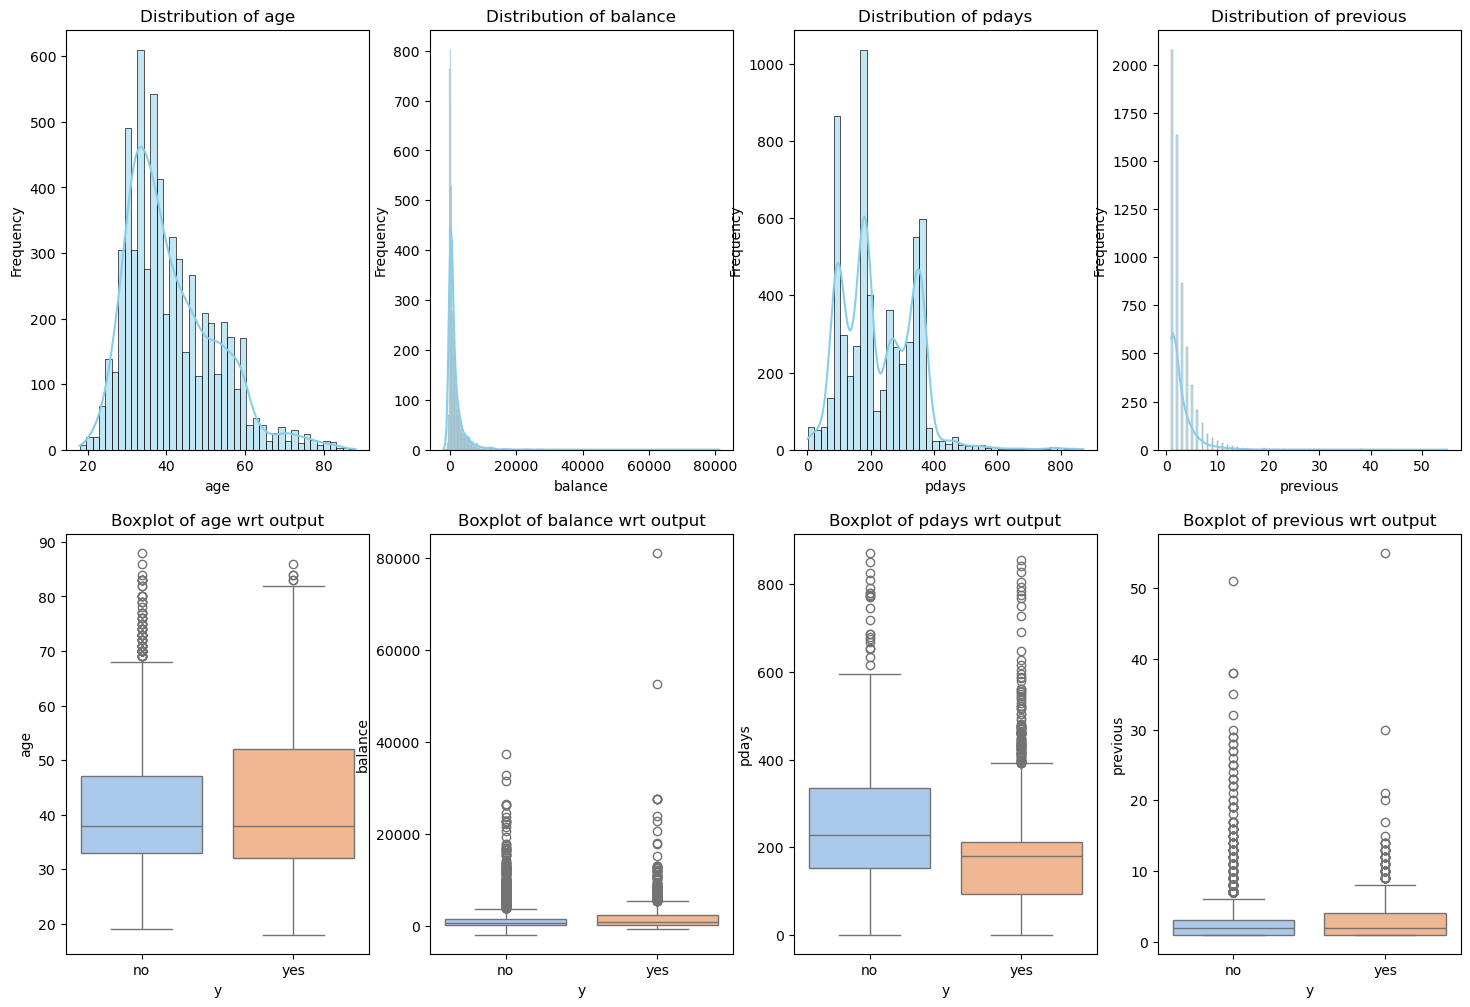

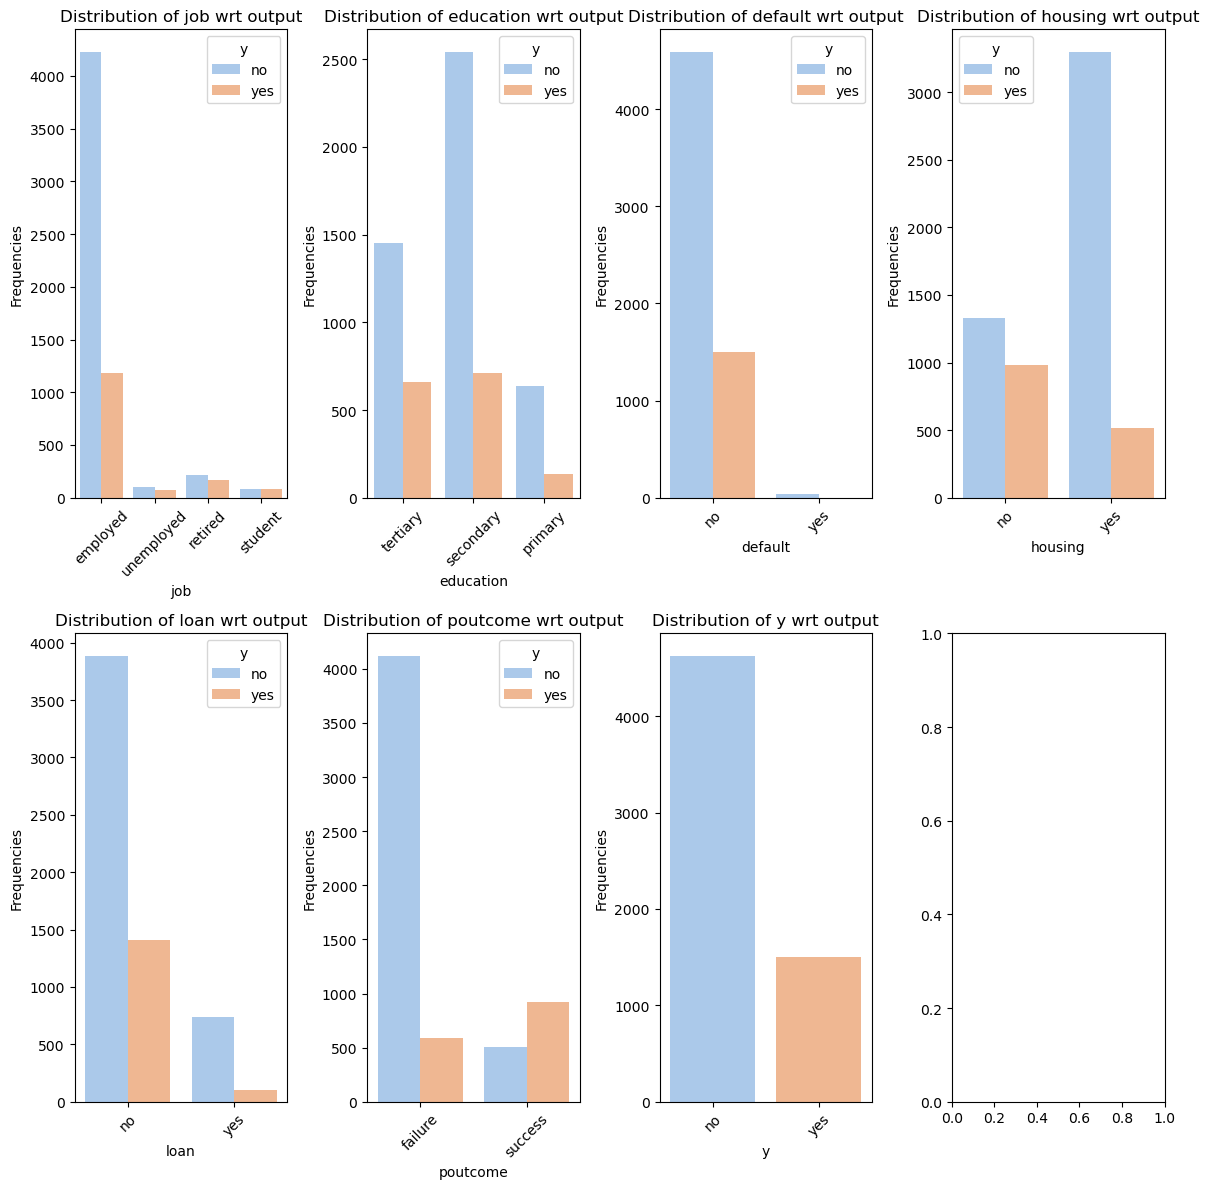

In [10]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Create a 2x5 grid for the plots (left for distribution, right for boxplots)
fig, axes = plt.subplots(2, 4, figsize=(18, 12))  # 2 rows, 4 columns
axes = axes.ravel()

# Plot distribution for numerical variables on the left
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Plot boxplot for numerical variables with respect to target on the right
for i, col in enumerate(num_cols):
    sns.boxplot(x=df['y'], y=df[col], palette='pastel', ax=axes[i + len(num_cols)], hue=df['y'], legend=False)
    axes[i + len(num_cols)].set_title(f"Boxplot of {col} wrt output")
    axes[i + len(num_cols)].set_xlabel("y")
    axes[i + len(num_cols)].set_ylabel(col)

# Frequencies for each categorical variable wrt target
fig, axes = plt.subplots(2, 4, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], hue=df['y'], palette='pastel', ax=axes[i])
    axes[i].set_title(f"Distribution of {col} wrt output")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequencies")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We now compute correlation among features and with output.

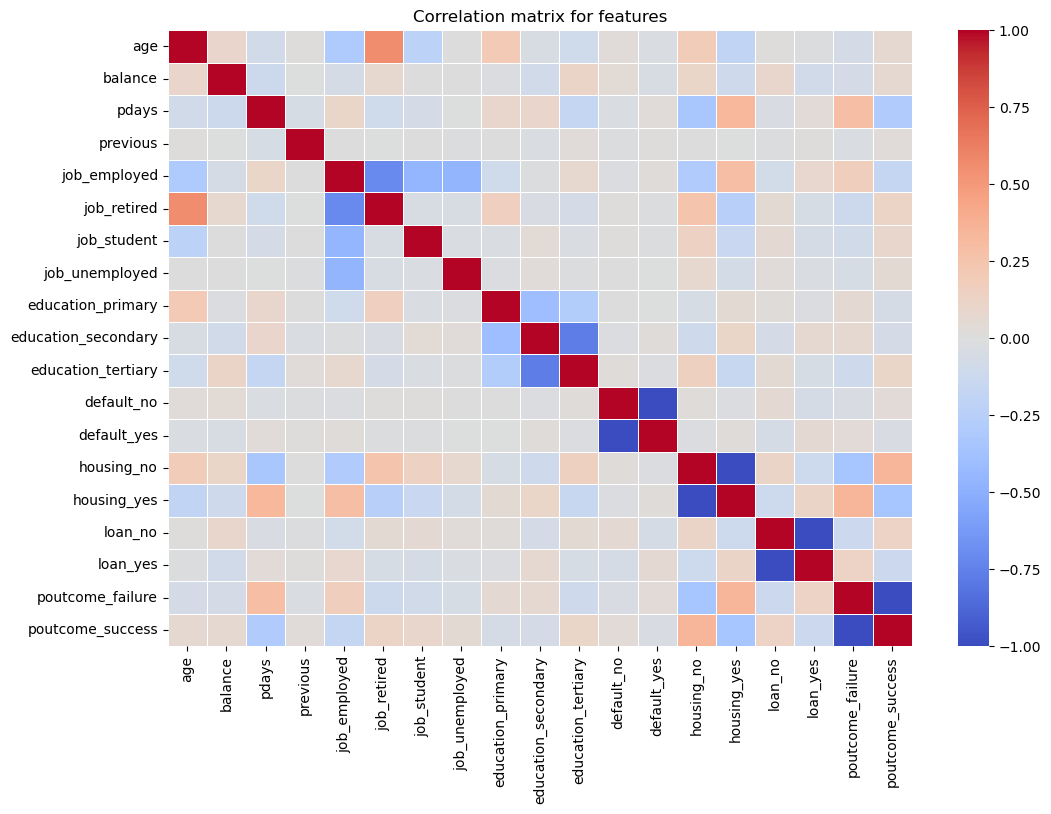

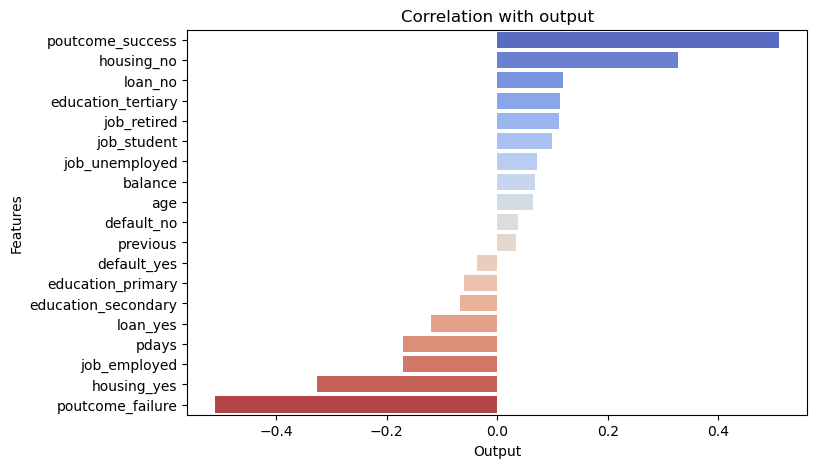

In [11]:
# Convert output type
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Consider just features and perform one-hot encoding for categorical ones
df_features = df.drop(columns = 'y')
df_encoded = pd.get_dummies(df_features, drop_first = False)
features_corr = df_encoded.corr()

# Correlation between features and output
df_encoded_with_output = df_encoded.copy()
df_encoded_with_output['y'] = df['y']
y_corr = df_encoded_with_output.corr()['y'].drop('y') 

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(features_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix for features")
plt.show()

plt.figure(figsize=(8, 5))
y_corr_sorted = y_corr.sort_values(ascending=False)  # Ordina per importanza
sns.barplot(x=y_corr_sorted.values, y=y_corr_sorted.index, palette='coolwarm', hue = y_corr_sorted.index, legend=False)

plt.xlabel("Output")
plt.ylabel("Features")
plt.title("Correlation with output")
plt.show()

# FEATURE SELECTION

We start by computing the entropy of the target.

In [16]:
#X = df_encoded.drop(columns=['y'])
X = pd.get_dummies(df_features, drop_first = False)
y = df['y']

def entropy(y):
    # Calcola l'entropia di una variabile
    prob = y.value_counts(normalize=True)  # Class probabilities
    return -np.sum(prob * np.log2(prob))  # Entropy formula

# Calcolo dell'entropia del target
H_Y = entropy(y)
print(f"Target Entropy H(Y): {H_Y}")

Target Entropy H(Y): 0.8036311095951458


Compute Mutual Information between features and target and amog features.

In [18]:
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI': mi}).sort_values(by='MI', ascending=False)
print("\nMutual Information between features and target:")
print(mi_df)


Mutual Information between features and target:
                Feature        MI
18     poutcome_success  0.118142
17     poutcome_failure  0.118141
2                 pdays  0.073689
1               balance  0.054621
14          housing_yes  0.052409
13           housing_no  0.047821
0                   age  0.022747
4          job_employed  0.016568
5           job_retired  0.010104
12          default_yes  0.007902
3              previous  0.006292
15              loan_no  0.005651
9   education_secondary  0.003496
11           default_no  0.002972
16             loan_yes  0.002835
6           job_student  0.001041
10   education_tertiary  0.000741
7        job_unemployed  0.000000
8     education_primary  0.000000


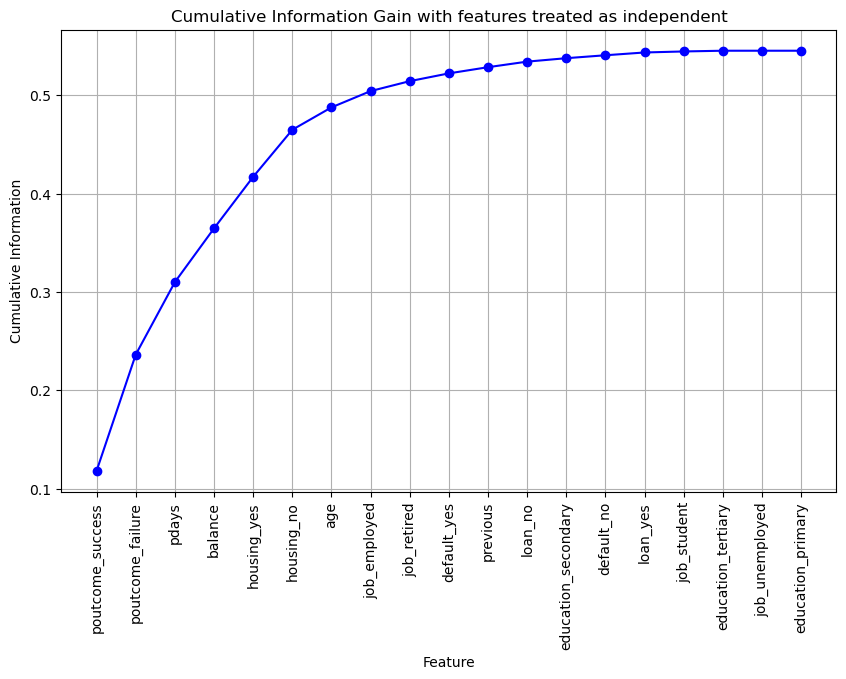

In [20]:
# Apply chain rule. Compute MI incrementally adding each time a new feature. Elbow rule to pick number of features

mi_sorted = mi_df.sort_values(by='MI', ascending=False)
mi_cumsum = mi_sorted['MI'].cumsum()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mi_sorted['Feature'], mi_cumsum, marker='o', linestyle='-', color='b')
plt.title('Cumulative Information Gain with features treated as independent')
plt.xlabel('Feature')
plt.ylabel('Cumulative Information')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [22]:
def feature_mutual_information(X):
    mi_matrix = pd.DataFrame(index=X.columns, columns=X.columns)
    for col1 in X.columns:
        for col2 in X.columns:
            mi_matrix.loc[col1, col2] = mutual_info_score(X[col1], X[col2])
    return mi_matrix

selected_features_full = [
    'poutcome_success','poutcome_failure', 'pdays', 'housing_yes','housing_no', 'balance'
]

X_reduced_full = X[selected_features_full]

mi_features_complete = feature_mutual_information(X)
print("\nMutual Information among features:")
print(mi_features_complete)

mi_features_reduced_full = feature_mutual_information(X_reduced_full)
print("\nMutual Information among features full reduced:")
print(mi_features_reduced_full)


Mutual Information among features:
                          age   balance     pdays  previous job_employed  \
age                  3.718641  2.710468  1.093824  0.083064     0.118229   
balance              2.710468  7.420714  4.366688  1.040573     0.237683   
pdays                1.093824  4.366688  5.615287  0.369634     0.064904   
previous             0.083064  1.040573  0.369634  1.862458     0.002028   
job_employed         0.118229  0.237683  0.064904  0.002028     0.362693   
job_retired          0.149845  0.171601  0.048468  0.001594     0.151688   
job_student          0.055125  0.088551  0.029977  0.001587      0.06165   
job_unemployed       0.005716  0.087837  0.028341  0.002058      0.06359   
education_primary    0.029377  0.221091  0.046222   0.00204     0.004007   
education_secondary  0.011404  0.371547  0.058975  0.004512     0.000038   
education_tertiary   0.018404  0.356591  0.078664  0.004286     0.003043   
default_no           0.004216  0.030424  0.013687  0

# RANDOM FOREST

In [26]:
# Function to evaluate metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Prediction over training set
    y_train_pred = model.predict(X_train)
    # Prediction over test set
    y_test_pred = model.predict(X_test)

    # Compute metrics over train and test set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print("Classification Report (Train):")
    print(classification_report(y_train, y_train_pred))
    print("Classification Report (Test):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Plot Confusion Matrix for Train and Test
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False, annot_kws={"size": 16})
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False, annot_kws={"size": 16})
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

## FULL DATASET

We split in train and test set.

In [28]:
# Set seed
np.random.seed(19)

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(columns=['y'])
y = df_encoded['y'].astype(int)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Splitting the dataset in 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

# Use SMOTE for class imbalance
#X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.3, random_state=19)
#smote = SMOTE(random_state=19)
#X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (4293, 13)
Test set: (1840, 13)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 350}
Train Accuracy: 0.8556, Test Accuracy: 0.8163
Train F1 Score: 0.7249, Test F1 Score: 0.6544
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3235
           1       0.68      0.77      0.72      1058

    accuracy                           0.86      4293
   macro avg       0.80      0.83      0.81      4293
weighted avg       0.86      0.86      0.86      4293

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1394
           1       0.60      0.72      0.65       446

    accuracy                           0.82      1840
   macro avg       0.75      0.78      0.76      1840
weighted avg       0.83      0.82      0.82      1840



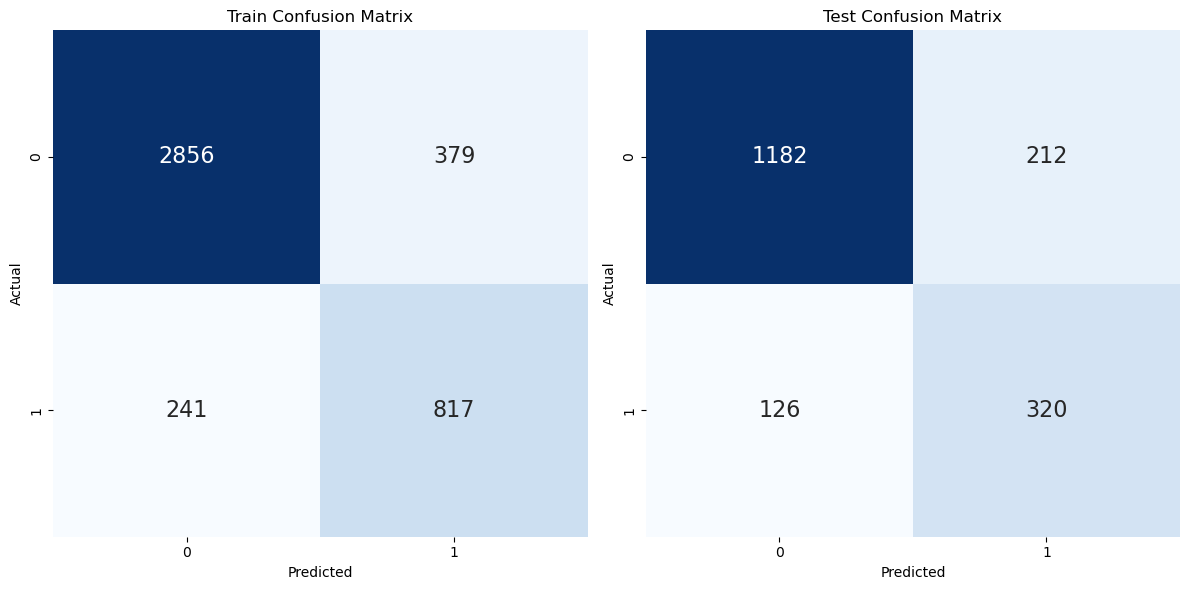

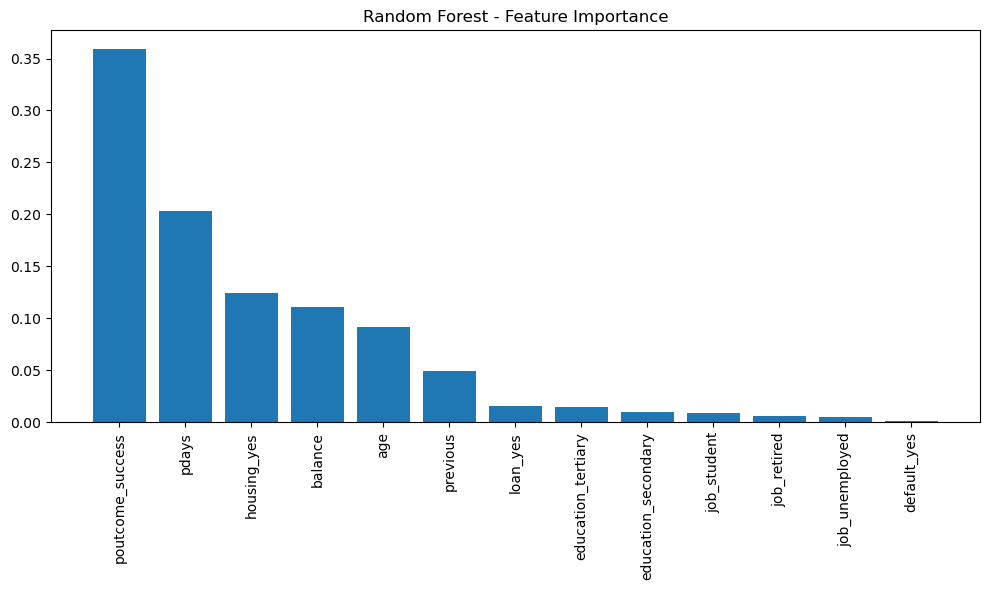

In [30]:
# If class imbalance
rf = RandomForestClassifier(class_weight = 'balanced', criterion='entropy', random_state=19) #

# Random Forest Classifier
#rf = RandomForestClassifier(random_state=19)

# Grid of parameters to search
param_grid_rf = {
    'n_estimators': [350, 400],
    'max_depth': [7, 10],
    'min_samples_split': [5],
    'min_samples_leaf': [3]
}

# GridSearch
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Model performances
best_rf = grid_search_rf.best_estimator_
evaluate_model(best_rf, X_train, X_test, y_train, y_test)


# Importance plot
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

## REDUCED DATASET (ELBOW RULE)

In [38]:
# Set seed
np.random.seed(19)

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

selected_features_full_2 = [
    'poutcome_success', 'pdays', 'housing_yes' , 'balance'
]

X = df_encoded[selected_features_full_2]
y = df_encoded['y'].astype(int)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Splitting the dataset in 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

# Use SMOTE for class imbalance
#X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.3, random_state=19)
#smote = SMOTE(random_state=19)
#X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (4293, 4)
Test set: (1840, 4)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest:
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}
Train Accuracy: 0.8178, Test Accuracy: 0.8027
Train F1 Score: 0.6641, Test F1 Score: 0.6438
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3235
           1       0.61      0.73      0.66      1058

    accuracy                           0.82      4293
   macro avg       0.76      0.79      0.77      4293
weighted avg       0.83      0.82      0.82      4293

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1394
           1       0.57      0.74      0.64       446

    accuracy                           0.80      1840
   macro avg       0.74      0.78      0.75      1840
weighted avg       0.83      0.80      0.81      1840



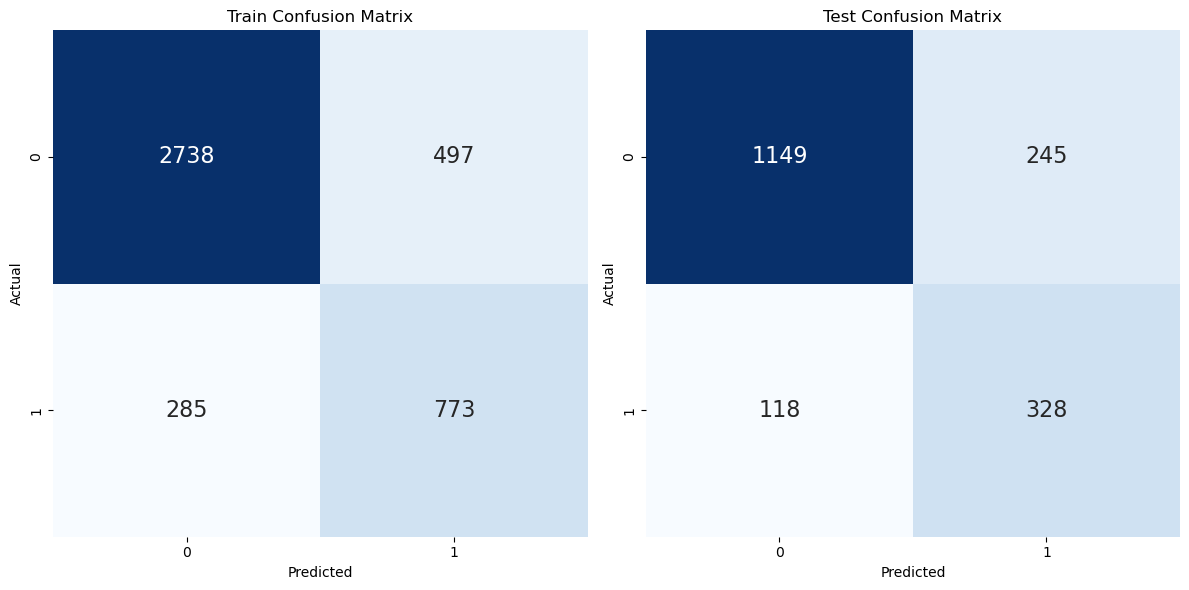

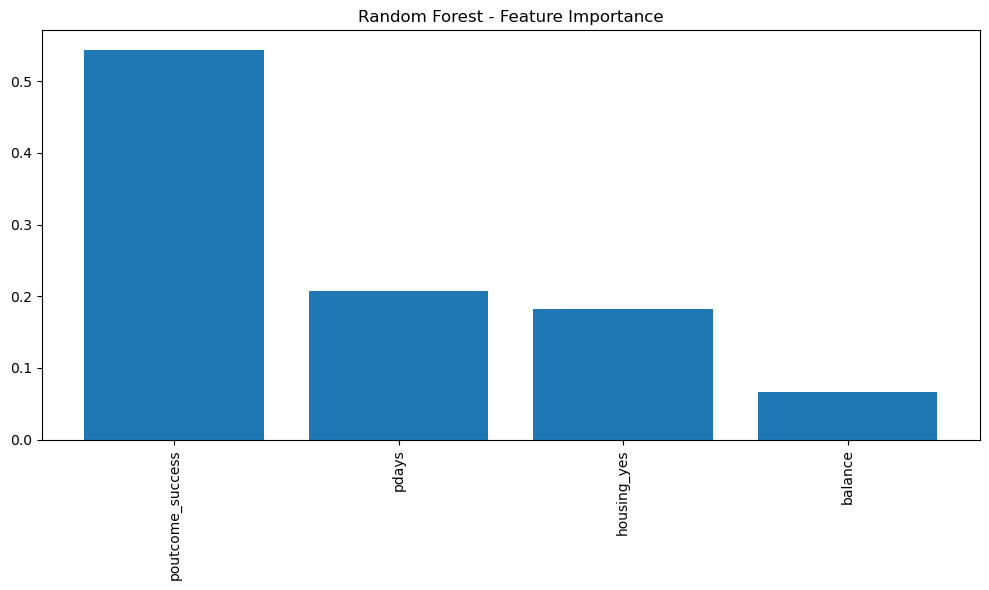

In [40]:
# If class imbalance
rf = RandomForestClassifier(class_weight = 'balanced', criterion='entropy', random_state=19) #

# Random Forest Classifier
#rf = RandomForestClassifier(random_state=19)

# Grid of parameters to search
param_grid_rf = {
    'n_estimators': [200, 250],
    'max_depth': [5, 7],
    'min_samples_split': [5],
    'min_samples_leaf': [3]
}

# GridSearch
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Model performances
best_rf = grid_search_rf.best_estimator_
evaluate_model(best_rf, X_train, X_test, y_train, y_test)


# Importance plot
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

## REDUCED DATASET (DATA PROCESSING INEQUALITY)

In [46]:
# Set seed
np.random.seed(19)

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

selected_features_full_2 = [
    'poutcome_success', 'pdays', 'housing_yes'
]

X = df_encoded[selected_features_full_2]
y = df_encoded['y'].astype(int)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Splitting the dataset in 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

# Use SMOTE for class imbalance
#X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.3, random_state=19)
#smote = SMOTE(random_state=19)
#X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (4293, 3)
Test set: (1840, 3)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest:
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}
Train Accuracy: 0.8041, Test Accuracy: 0.7870
Train F1 Score: 0.6520, Test F1 Score: 0.6350
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      3235
           1       0.58      0.74      0.65      1058

    accuracy                           0.80      4293
   macro avg       0.74      0.78      0.76      4293
weighted avg       0.83      0.80      0.81      4293

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1394
           1       0.54      0.76      0.64       446

    accuracy                           0.79      1840
   macro avg       0.73      0.78      0.74      1840
weighted avg       0.82      0.79      0.80      1840



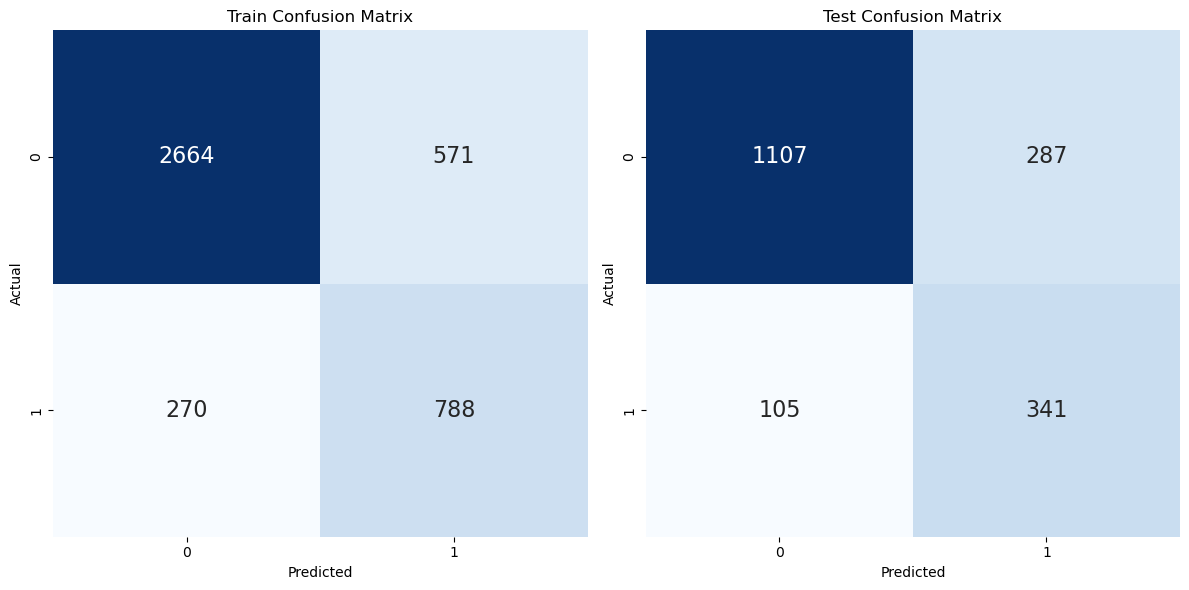

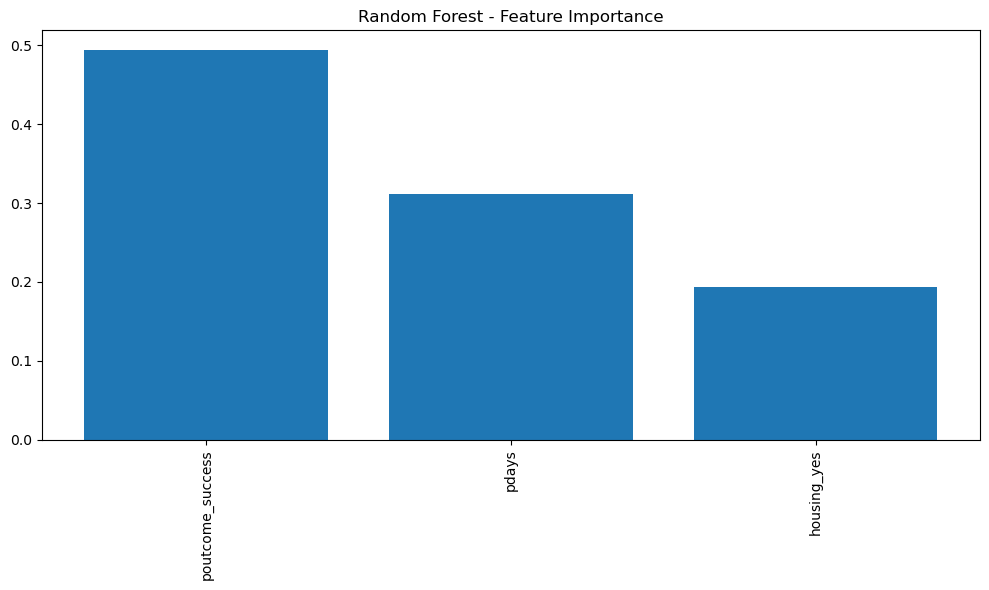

In [48]:
# If class imbalance
rf = RandomForestClassifier(class_weight = 'balanced', criterion='entropy', random_state=19) #

# Random Forest Classifier
#rf = RandomForestClassifier(random_state=19)

# Grid of parameters to search
param_grid_rf = {
    'n_estimators': [200, 250],
    'max_depth': [5, 7],
    'min_samples_split': [5],
    'min_samples_leaf': [3]
}

# GridSearch
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Model performances
best_rf = grid_search_rf.best_estimator_
evaluate_model(best_rf, X_train, X_test, y_train, y_test)


# Importance plot
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# ENTROPY ANALYSIS

In [ ]:
def plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide = 0.05, y_test=None, predictions=None, entropy_per_sample=None):

    bins = np.arange(0, 1 + slide, slide)
    hist_correct, bin_edges = np.histogram(entropy_correct, bins=bins)
    hist_incorrect, _ = np.histogram(entropy_incorrect, bins=bins)

    total_in_bin = hist_correct + hist_incorrect
    total_observations = np.sum(total_in_bin)

    print("Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | ")
    print("---------------------------------------------------------------------------------------------------")
    for i in range(len(bins) - 1):
        total = total_in_bin[i]
        correct = hist_correct[i]
        incorrect = hist_incorrect[i]
        percentage = (total / total_observations) * 100
        percentage_correct = (correct / total) * 100 if total > 0 else 0
        percentage_incorrect = (incorrect / total) * 100 if total > 0 else 0
        print(f"{bins[i]:.2f} - {bins[i+1]:.2f}  | {total:>17} | {correct:>19} | {incorrect:>22} | {percentage:>20.2f}%")
        print(f"    Correctly Classified Percentage: {percentage_correct:.2f}%")
        print(f"    Incorrectly Classified Percentage: {percentage_incorrect:.2f}%")

    # First plot
    plt.figure(figsize=(12, 6))
    plt.bar(bins[:-1], hist_correct, width=slide, label='Correctly Classified', color='lightgreen', edgecolor='black', alpha=0.7)
    plt.bar(bins[:-1], hist_incorrect, width=slide, label='Incorrectly Classified', color='lightcoral', edgecolor='black', alpha=0.7, bottom=hist_correct)
    
    plt.title('Total Entropy Distribution by Classification (Correct vs Incorrect)')
    plt.xlabel('Entropy')
    plt.ylabel('Number of Observations')
    plt.legend()
    plt.grid(True)
    
    for i in range(len(bins) - 1):
        total = total_in_bin[i]
        correct = hist_correct[i]
        incorrect = hist_incorrect[i]
        
        if total > 0:
            correct_percentage = (correct / total) * 100
            incorrect_percentage = (incorrect / total) * 100
            plt.text(bins[i] + slide, hist_correct[i] + 5, f'{correct_percentage:.1f}%', ha='center', va='bottom', fontsize=10, color='darkgreen')
            plt.text(bins[i] + slide, hist_correct[i] + hist_incorrect[i] + 5, f'{incorrect_percentage:.1f}%', ha='center', va='bottom', fontsize=10, color='darkred')

    plt.tight_layout()
    plt.show()

    # Second plot
    plt.figure(figsize=(12, 6))
    plt.bar(bins[:-1], total_in_bin, width=slide, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title('Total Entropy Distribution (All Observations) with Percentages')
    plt.xlabel('Entropy')
    plt.ylabel('Number of Observations')
    plt.grid(True)

    for i in range(len(bins) - 1):
        total = total_in_bin[i]
        percentage = (total / total_observations) * 100

        plt.text(bins[i] + slide, total + 5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, color='darkblue')

    plt.tight_layout()
    plt.show()

    # Third plot
    percentage_correct = (hist_correct / total_in_bin) * 100
    percentage_incorrect = (hist_incorrect / total_in_bin) * 100
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(bin_edges[:-1], percentage_correct, width=slide, color='green', edgecolor='black')
    plt.title("Percentage correctly classified")
    plt.xlabel("Entropy")
    plt.ylabel("Percentage (%)")
    plt.xticks(bin_edges, rotation=45)
    plt.grid(True, axis='y')

    plt.subplot(1, 2, 2)
    plt.bar(bin_edges[:-1], percentage_incorrect, width=slide, color='red', edgecolor='black')
    plt.title("Percentage incorrectly classified")
    plt.xlabel("Entropy")
    plt.ylabel("Percentage (%)")
    plt.xticks(bin_edges, rotation=45)
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    if y_test is not None and predictions is not None and entropy_per_sample is not None:
        y_test = np.array(y_test)
        predictions = np.array(predictions)
        entropy_per_sample = np.array(entropy_per_sample)
        classes = np.unique(y_test)

        for cls in classes:
            mask_class = y_test == cls
            mask_correct = (predictions == y_test) & mask_class
            mask_incorrect = (predictions != y_test) & mask_class

            ent_correct_cls = entropy_per_sample[mask_correct]
            ent_incorrect_cls = entropy_per_sample[mask_incorrect]

            hist_c, _ = np.histogram(ent_correct_cls, bins=bins)
            hist_ic, _ = np.histogram(ent_incorrect_cls, bins=bins)
            total_bin = hist_c + hist_ic
            total_sum = np.sum(total_bin)

            # 1. Stacked bar for class
            plt.figure(figsize=(12, 6))
            plt.bar(bins[:-1], hist_c, width=slide, label='Correctly Classified', color='lightgreen', edgecolor='black', alpha=0.7)
            plt.bar(bins[:-1], hist_ic, width=slide, label='Incorrectly Classified', color='lightcoral', edgecolor='black', alpha=0.7, bottom=hist_c)
            
            for i in range(len(bins) - 1):
                total = hist_c[i] + hist_ic[i]
                correct = hist_c[i]
                incorrect = hist_ic[i]
            
                if total > 0:
                    correct_percentage = (correct / total) * 100
                    incorrect_percentage = (incorrect / total) * 100
            
                    plt.text(bins[i] + slide / 2, hist_c[i] + 0.5, f'{correct_percentage:.1f}%', ha='center', va='bottom', fontsize=9, color='darkgreen')
                    plt.text(bins[i] + slide / 2, hist_c[i] + hist_ic[i] + 0.5, f'{incorrect_percentage:.1f}%', ha='center', va='bottom', fontsize=9, color='darkred')
            
            plt.title(f'Entropy Distribution for Class {cls}')
            plt.xlabel('Entropy')
            plt.ylabel('Number of Observations')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # 2. Total bins with percentages
            plt.figure(figsize=(12, 6))
            plt.bar(bins[:-1], total_bin, width=slide, color='skyblue', edgecolor='black', alpha=0.7)
            plt.title(f'Total Entropy Distribution for Class {cls} with Percentages')
            plt.xlabel('Entropy')
            plt.ylabel('Number of Observations')
            plt.grid(True)

            for i in range(len(bins) - 1):
                total = total_bin[i]
                percentage = (total / total_sum) * 100 if total_sum > 0 else 0
                plt.text(bins[i] + slide / 2, total + 1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9, color='darkblue')

            plt.tight_layout()
            plt.show()

            # 3. Percentages correct/mistake per bin
            percent_c = (hist_c / total_bin) * 100
            percent_ic = (hist_ic / total_bin) * 100

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.bar(bin_edges[:-1], percent_c, width=slide, color='green', edgecolor='black')
            plt.title(f"Class {cls}: % Correctly Classified")
            plt.xlabel("Entropy")
            plt.ylabel("Percentage (%)")
            plt.xticks(bin_edges, rotation=45)
            plt.grid(True, axis='y')

            plt.subplot(1, 2, 2)
            plt.bar(bin_edges[:-1], percent_ic, width=slide, color='red', edgecolor='black')
            plt.title(f"Class {cls}: % Incorrectly Classified")
            plt.xlabel("Entropy")
            plt.ylabel("Percentage (%)")
            plt.xticks(bin_edges, rotation=45)
            plt.grid(True, axis='y')

            plt.tight_layout()
            plt.show()

## FULL DATASET

Mean entropy for the model: 0.7508
Mean entropy for correctly classified samples: 0.7290
Mean entropy for incorrectly classified samples: 0.8800
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 1 |                   1 |                    

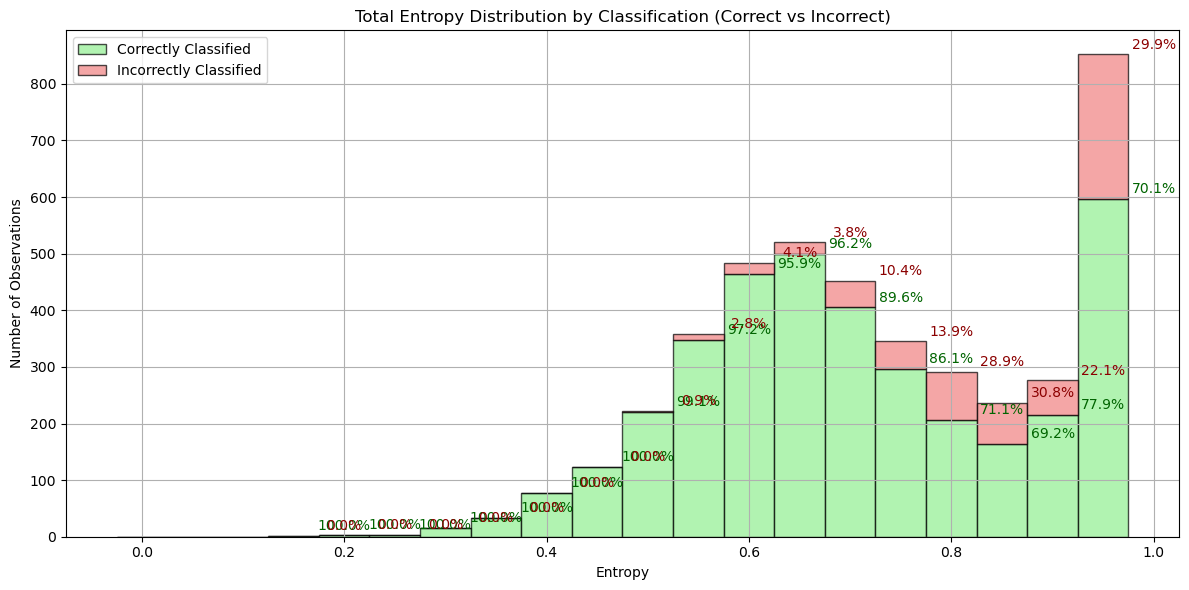

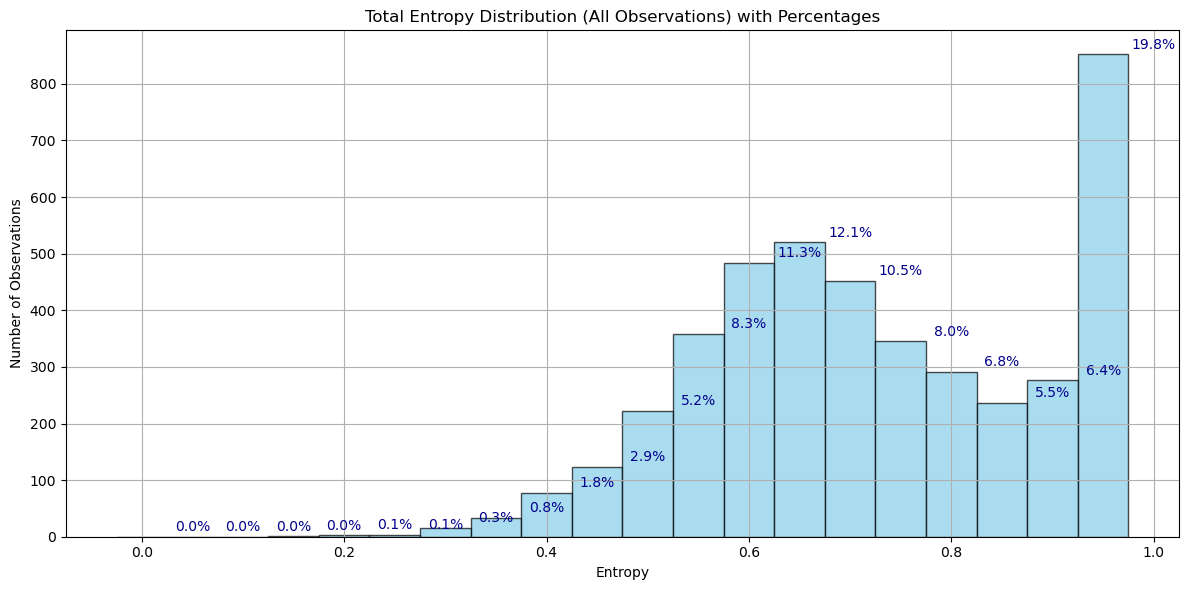

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


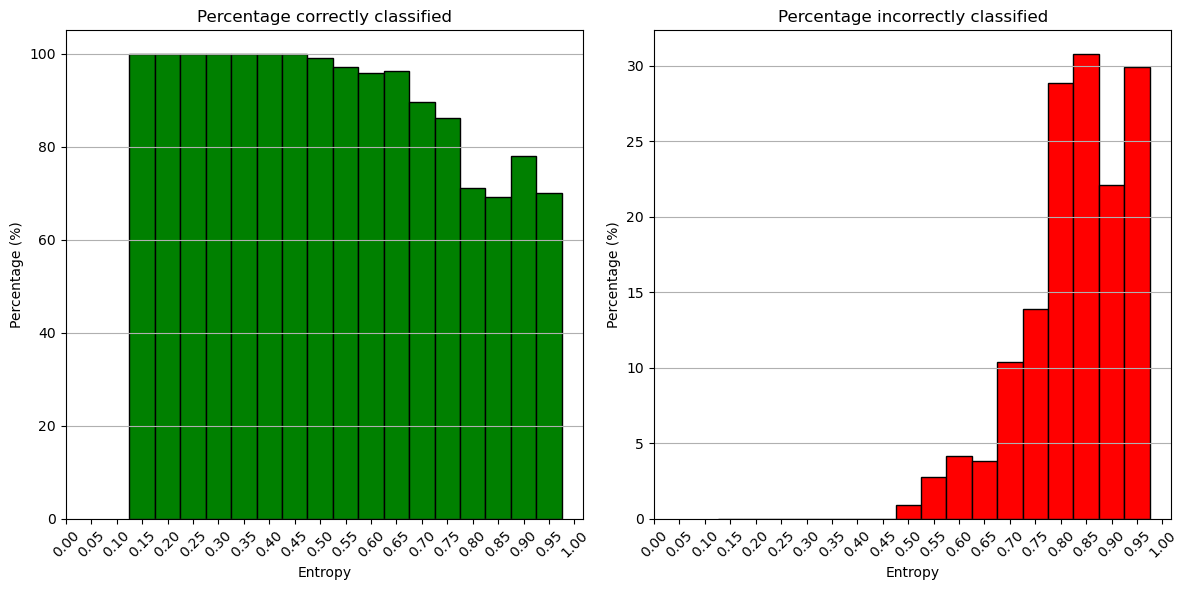

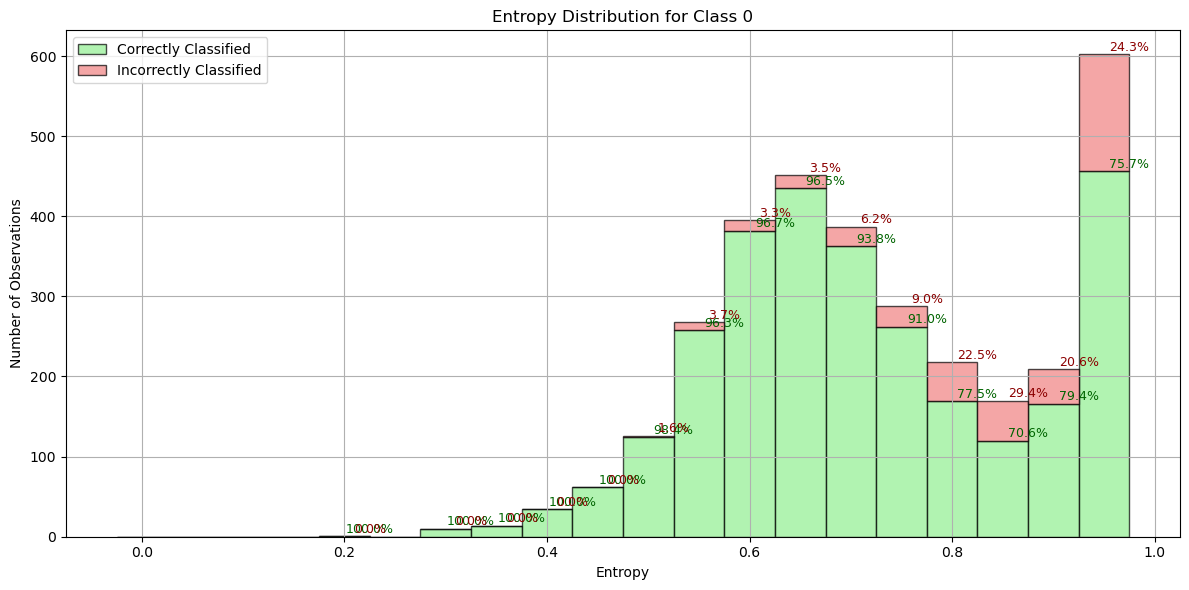

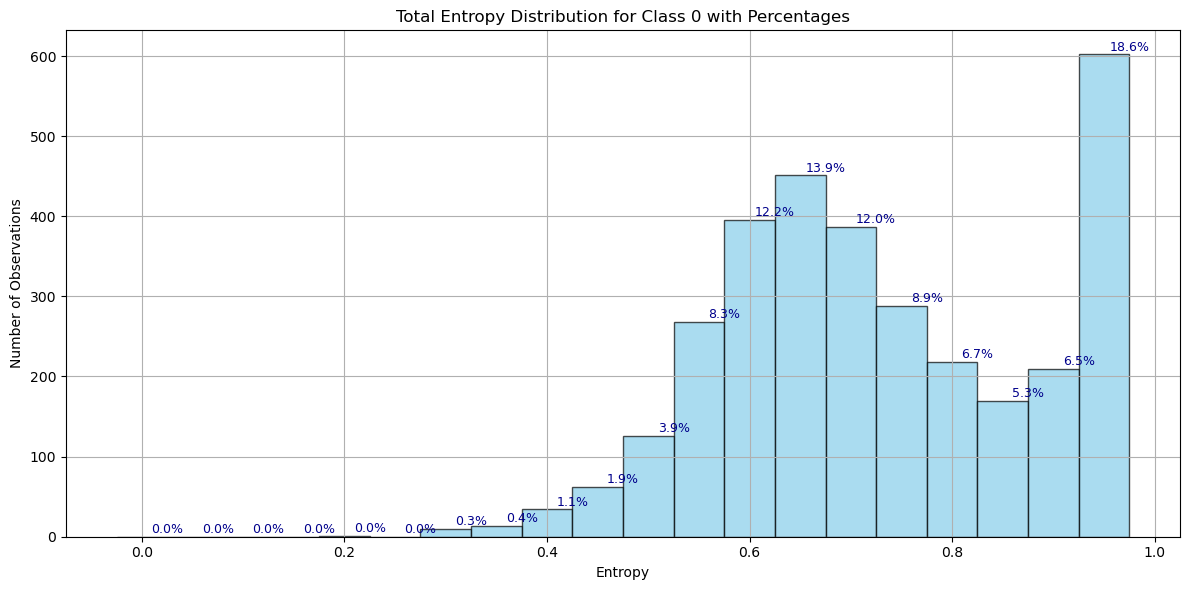

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


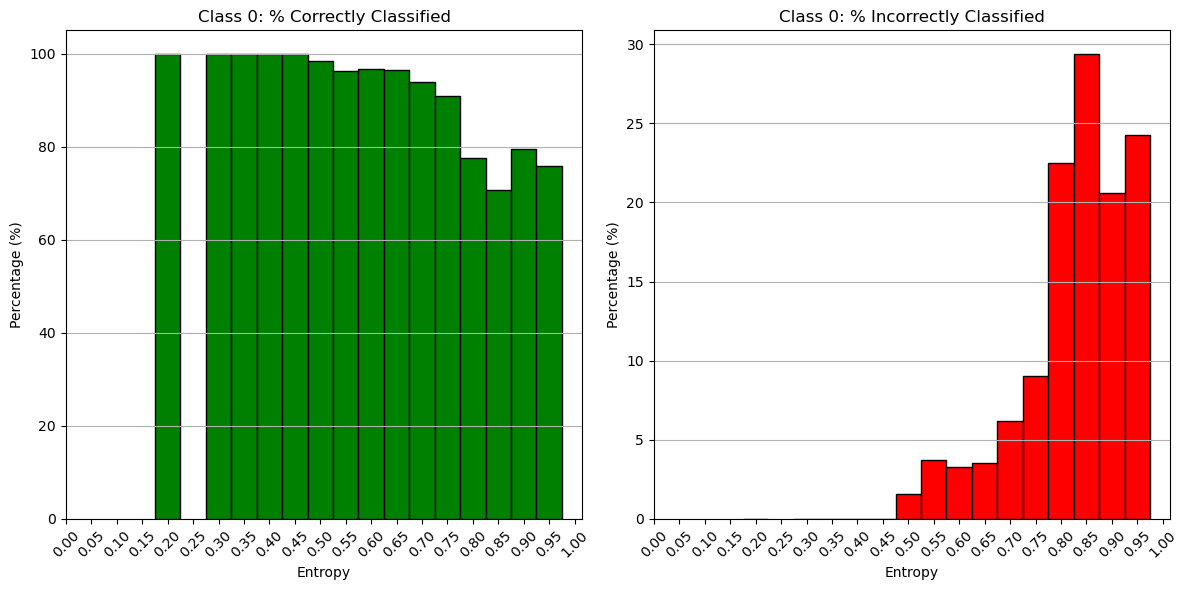

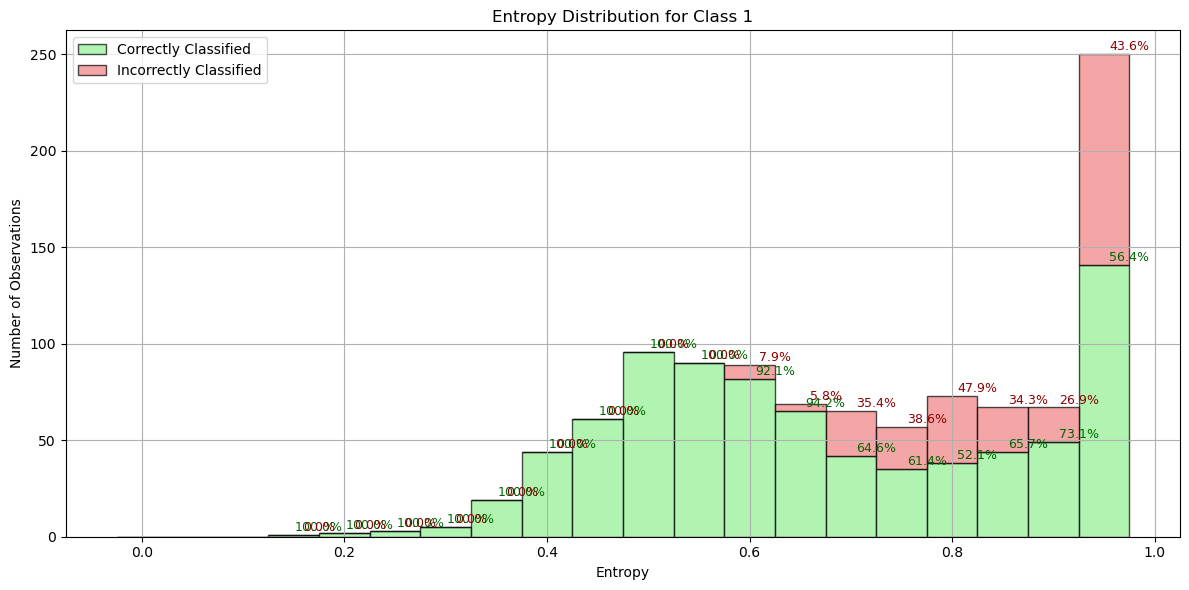

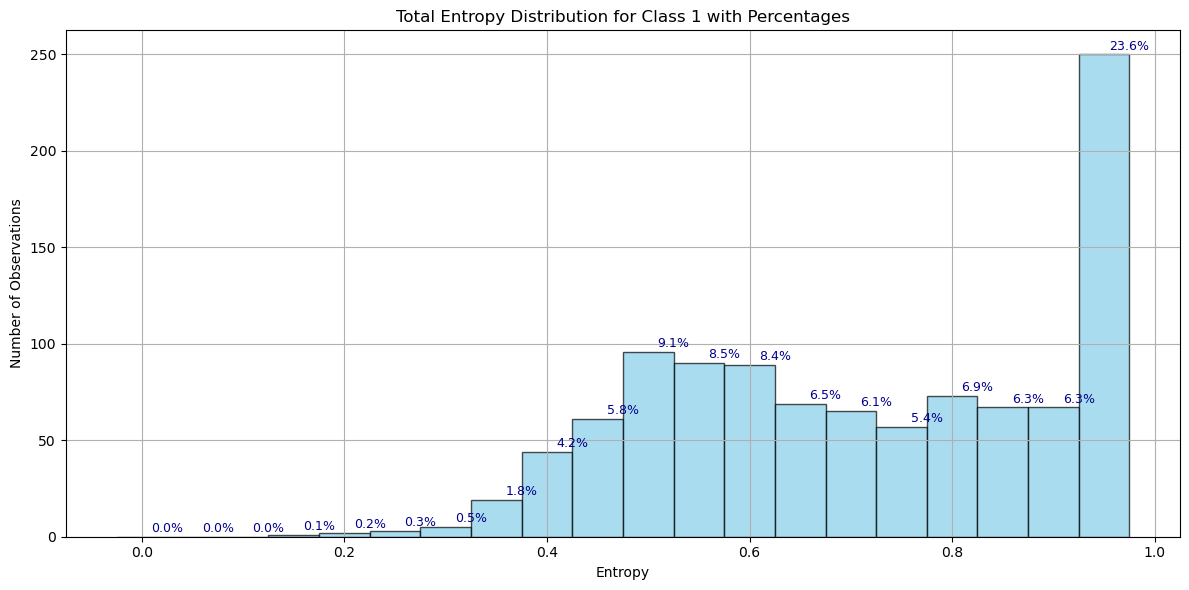

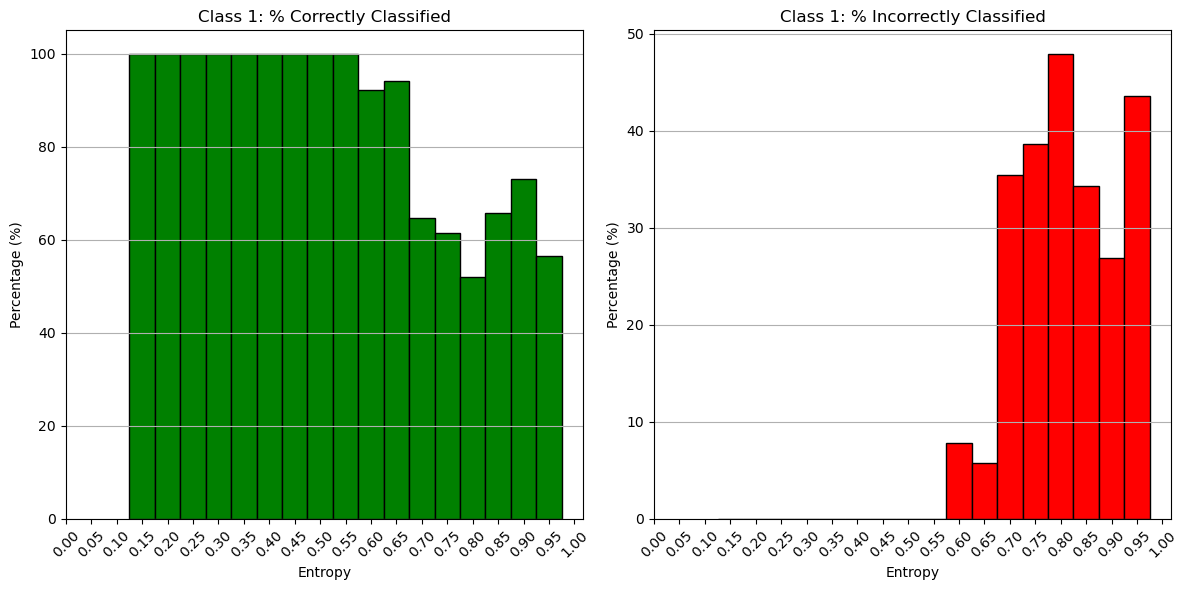

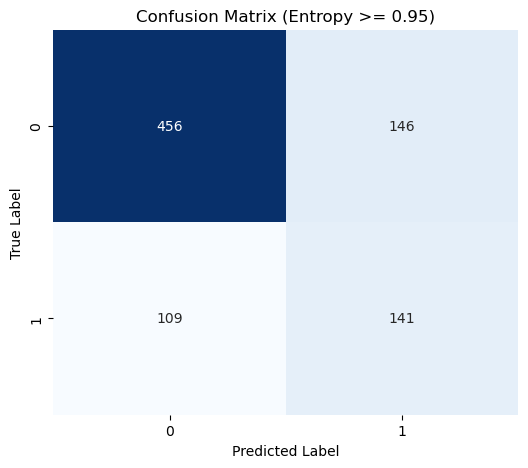

Mean entropy for the model: 0.7548
Mean entropy for correctly classified samples: 0.7387
Mean entropy for incorrectly classified samples: 0.8264
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 0 |                   0 |                    

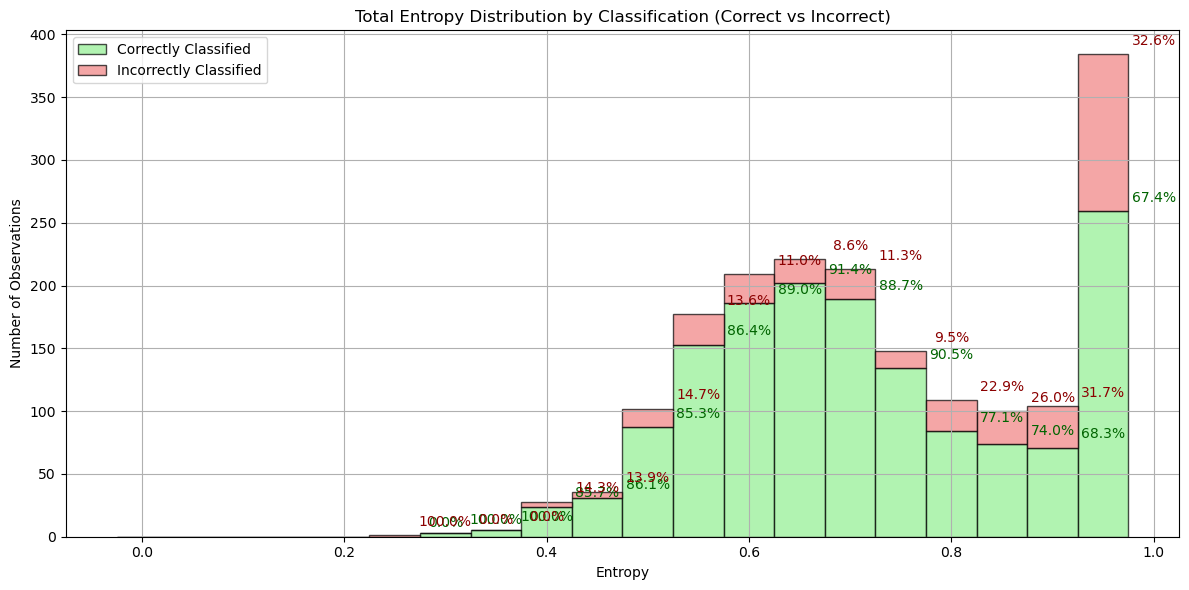

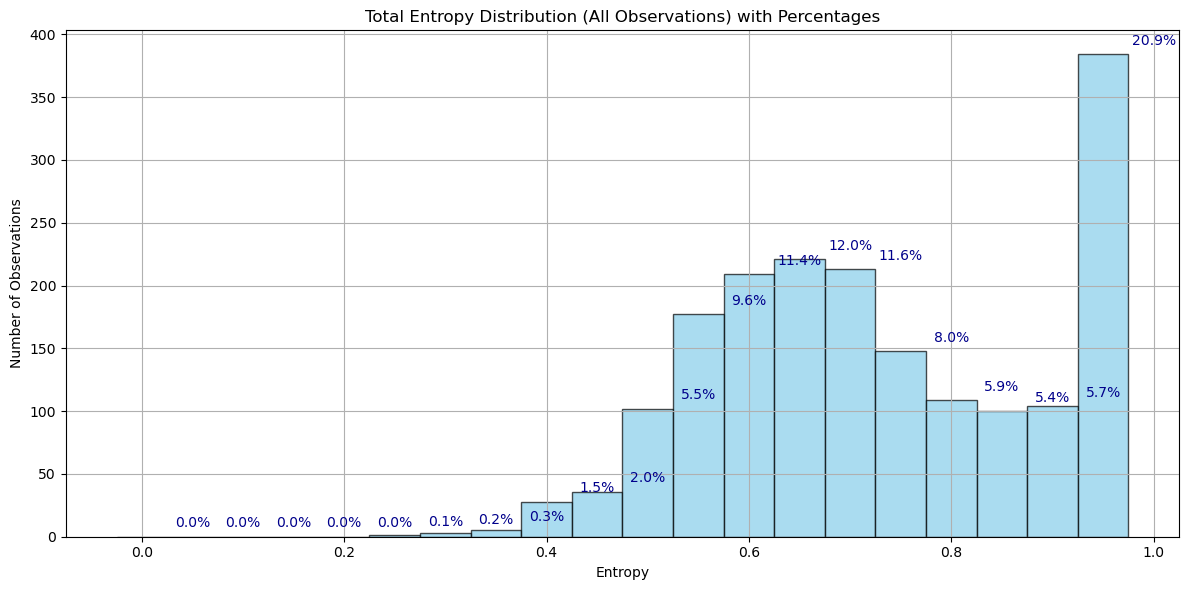

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


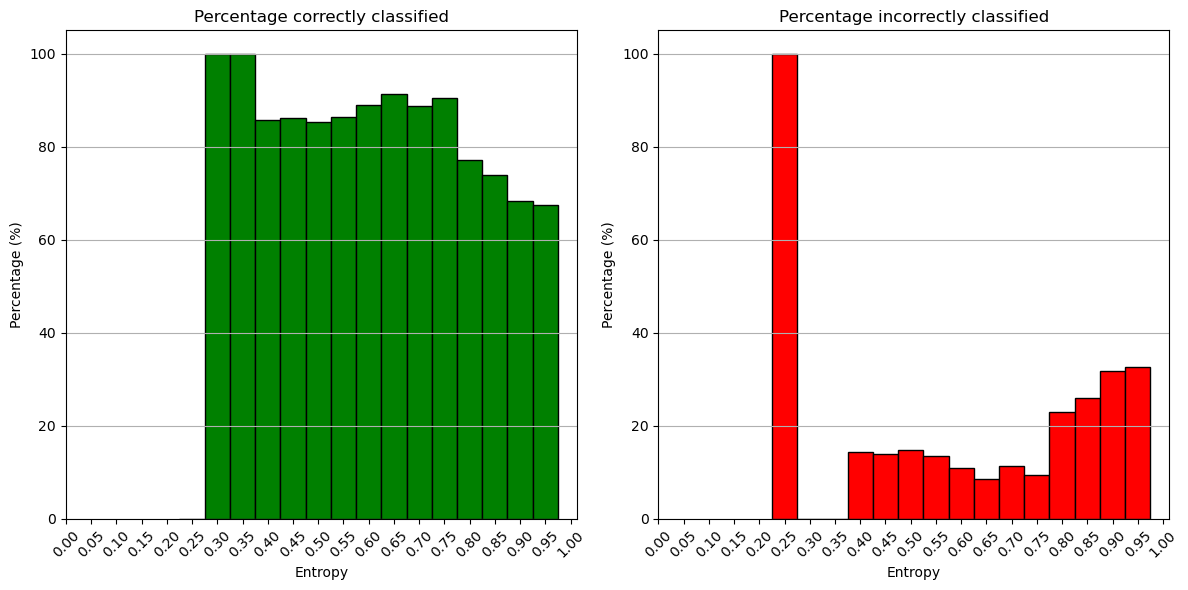

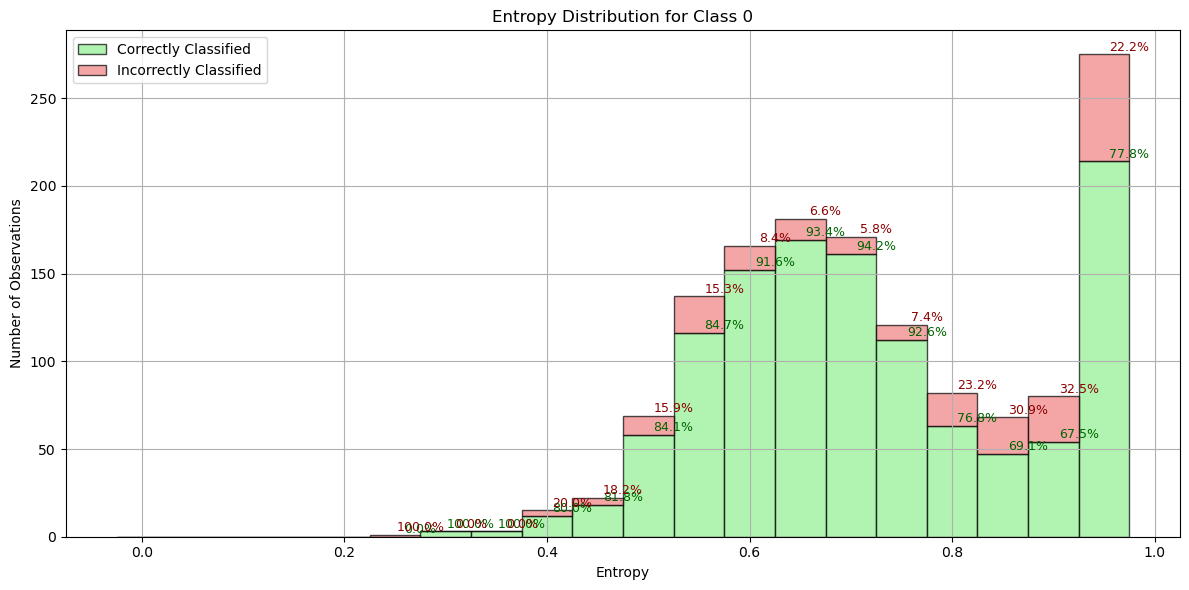

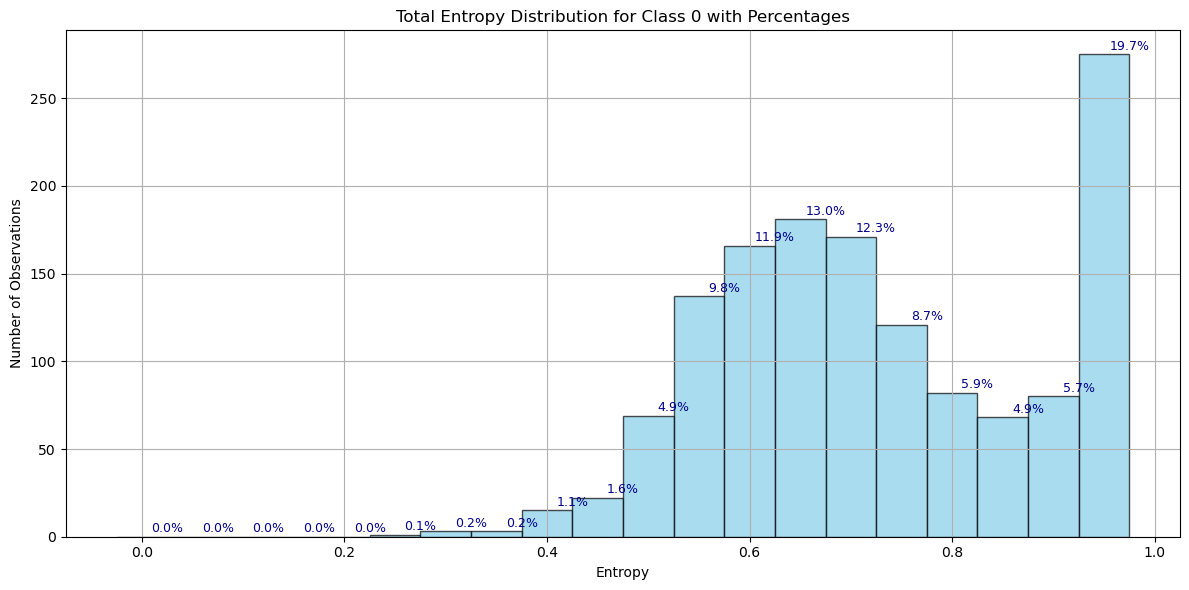

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


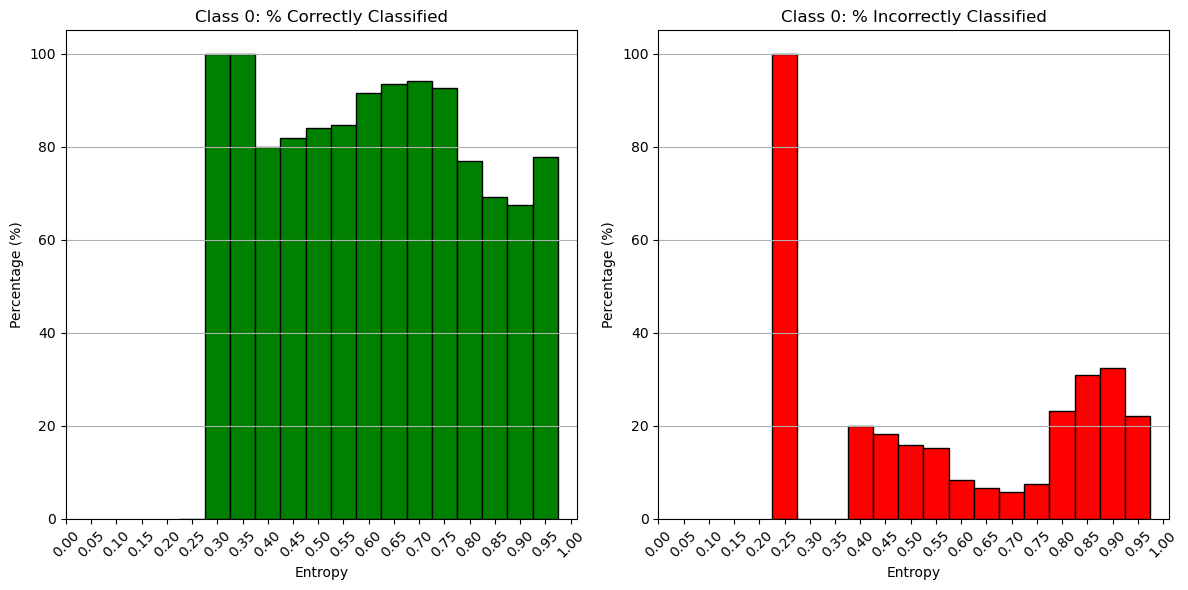

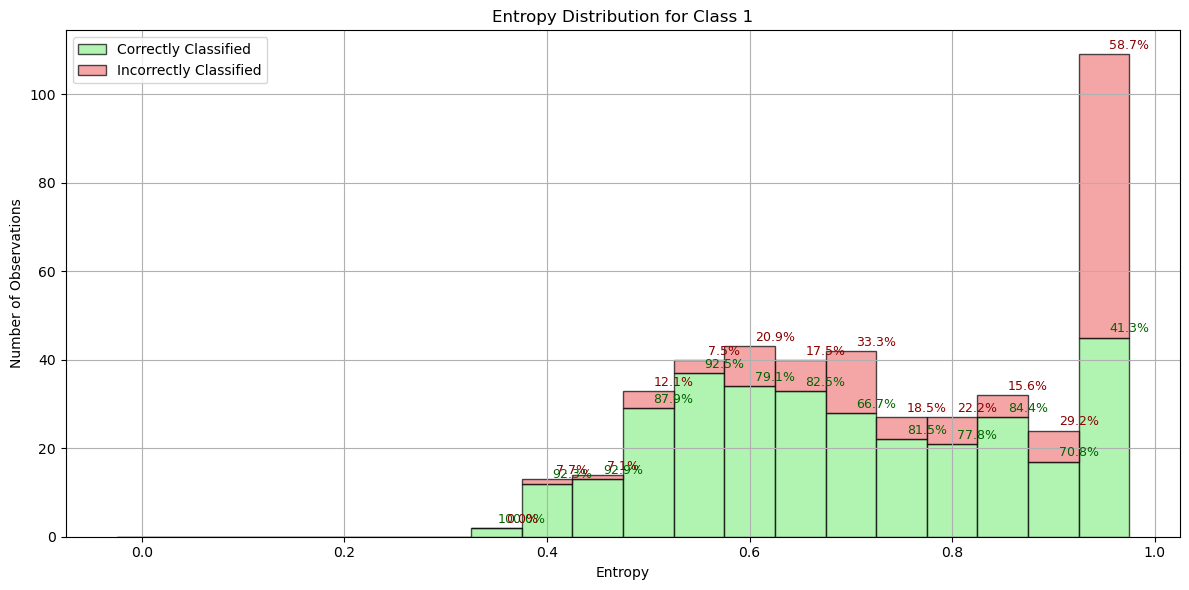

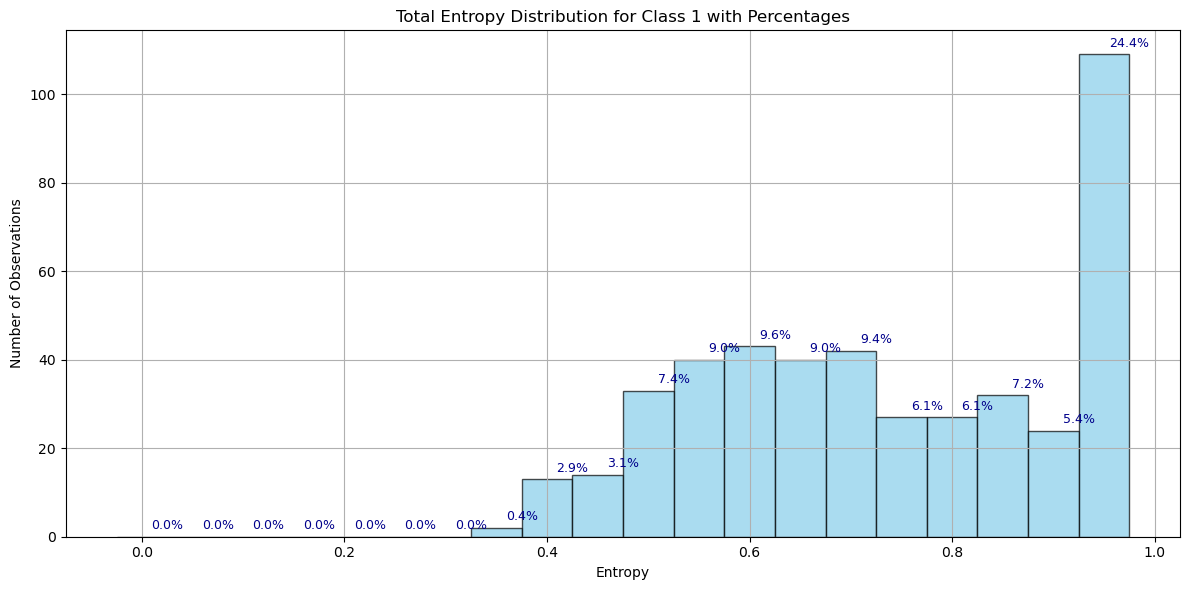

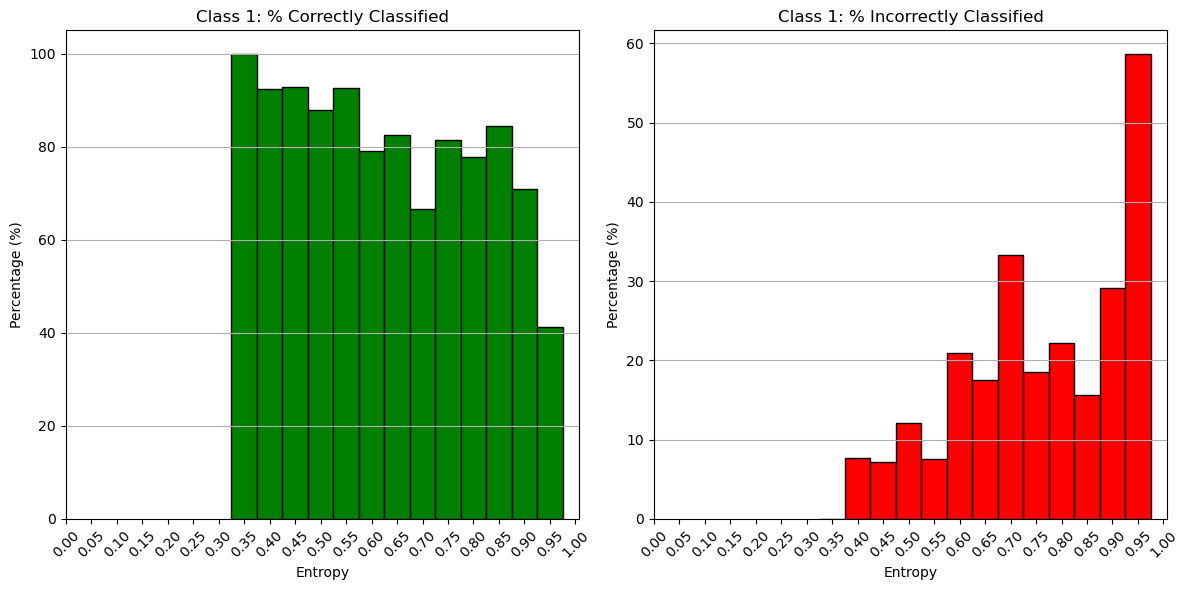

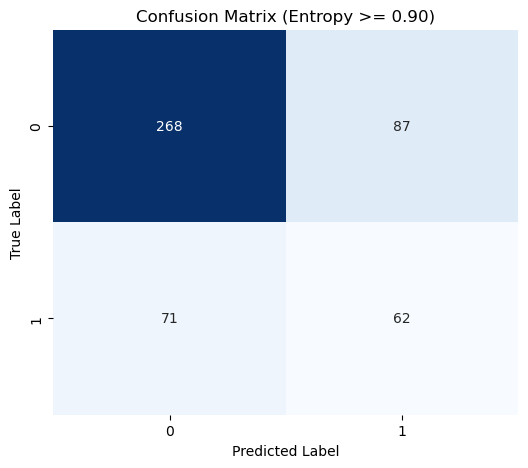

In [33]:
# Predicted probabilities over train set
probs = best_rf.predict_proba(X_train)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_train)
correct_predictions = (predictions == y_train)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_train, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.95

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_train_high_entropy = y_train.iloc[high_entropy_indices] if hasattr(y_train, "iloc") else y_train[high_entropy_indices]

cm = confusion_matrix(y_train_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()

# Predicted probabilities over test set
probs = best_rf.predict_proba(X_test)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_test)
correct_predictions = (predictions == y_test)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_test, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.9

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_test_high_entropy = y_test.iloc[high_entropy_indices] if hasattr(y_test, "iloc") else y_test[high_entropy_indices]

cm = confusion_matrix(y_test_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()

## REDUCED DATASET (ELBOW RULE)

Mean entropy for the model: 0.7605
Mean entropy for correctly classified samples: 0.7458
Mean entropy for incorrectly classified samples: 0.8261
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 0 |                   0 |                    

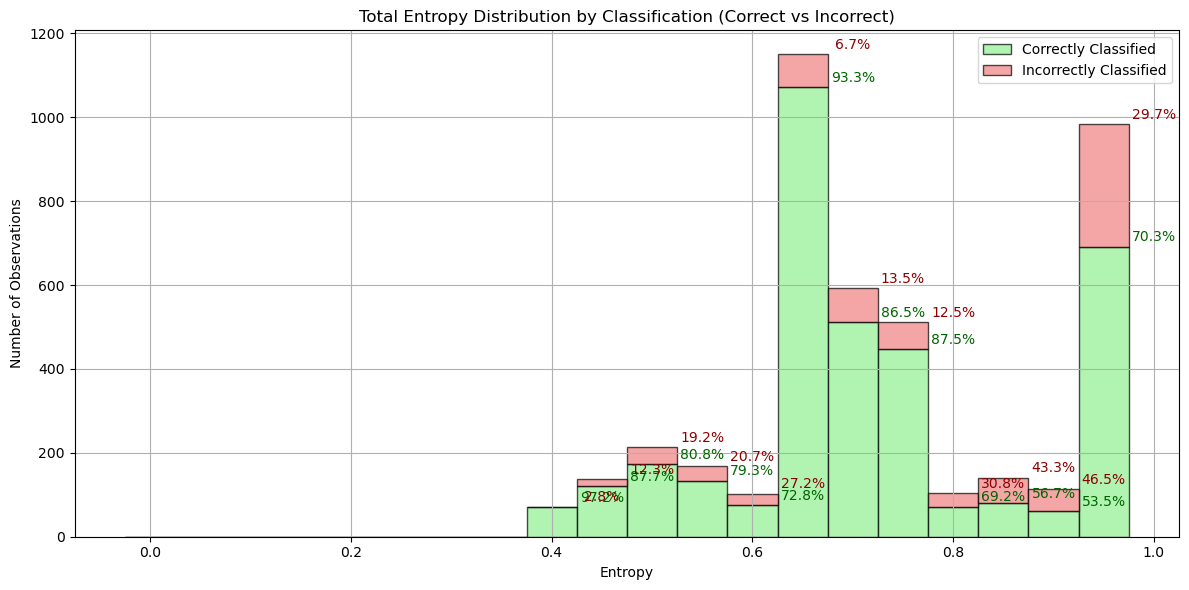

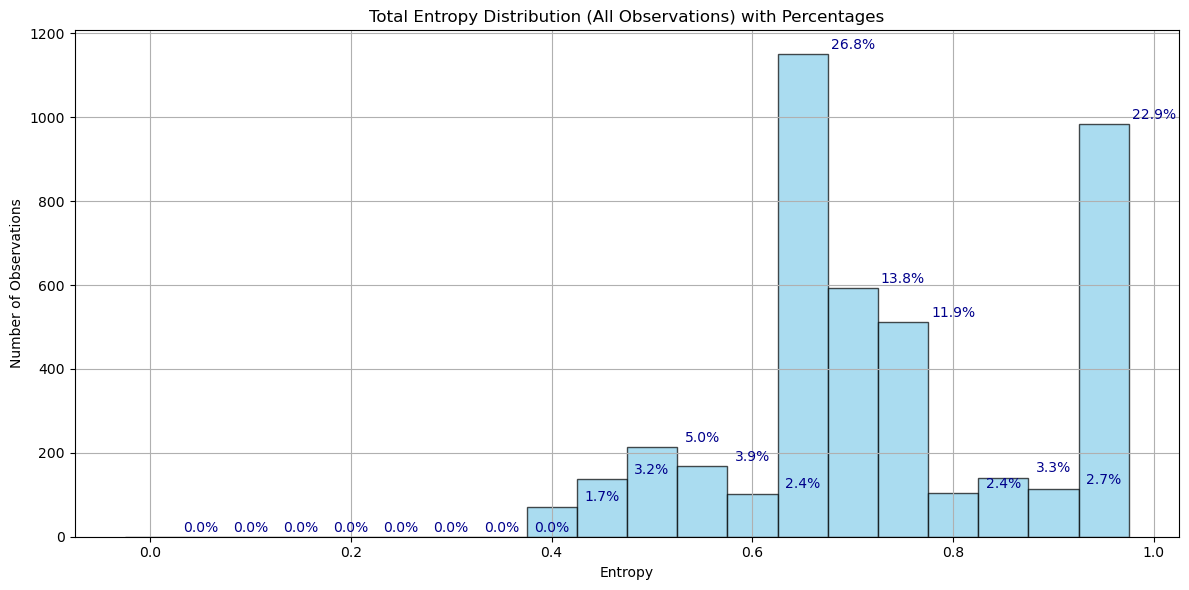

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


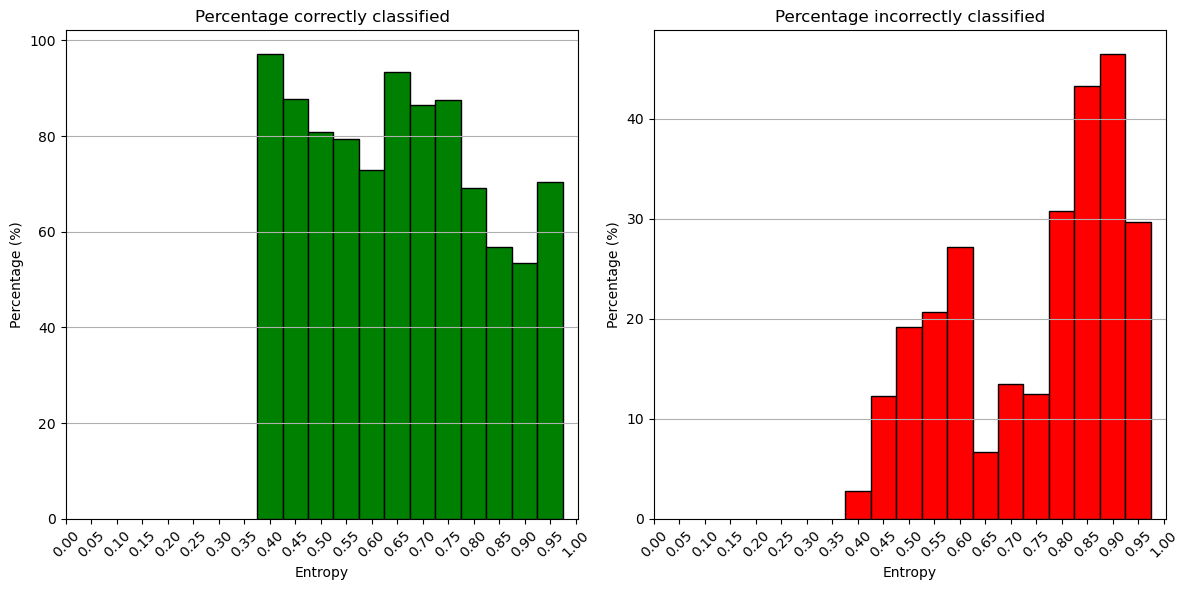

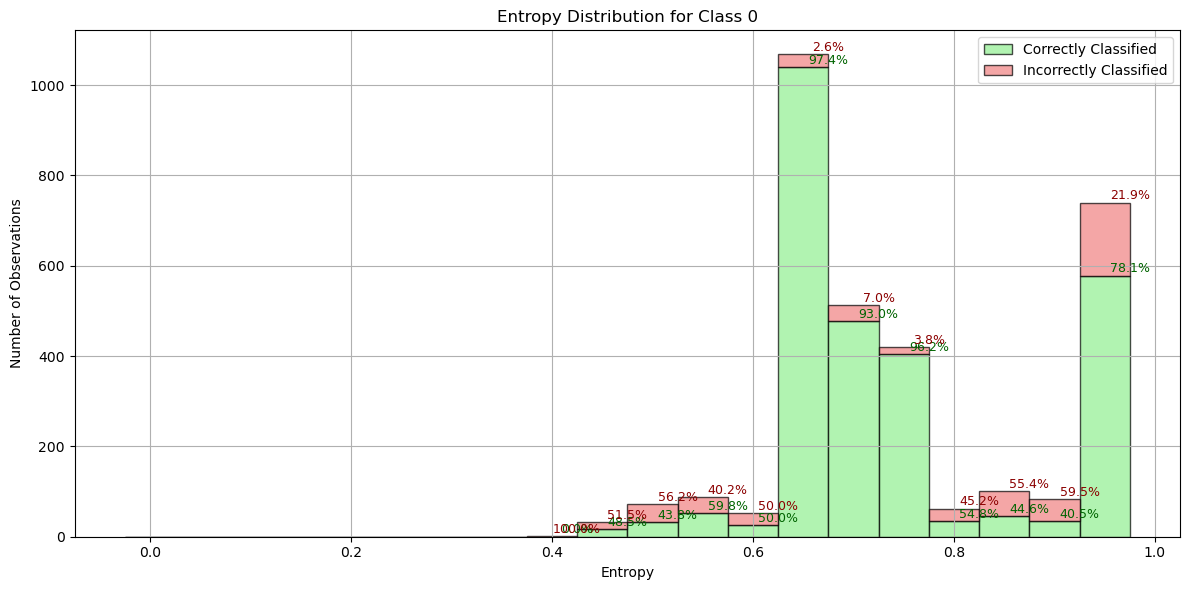

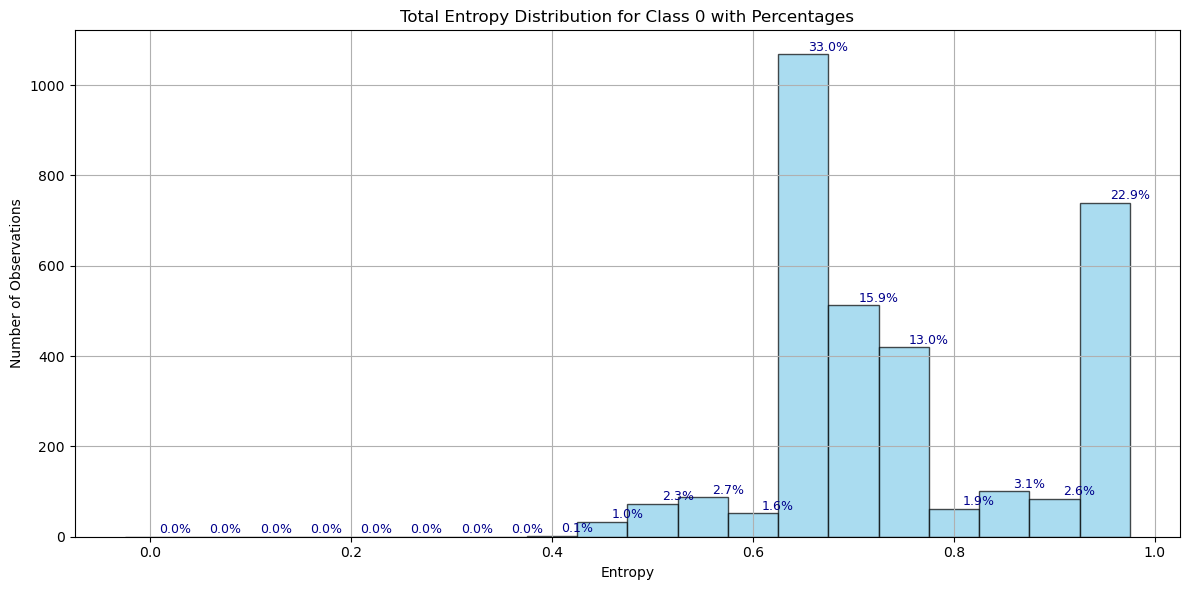

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


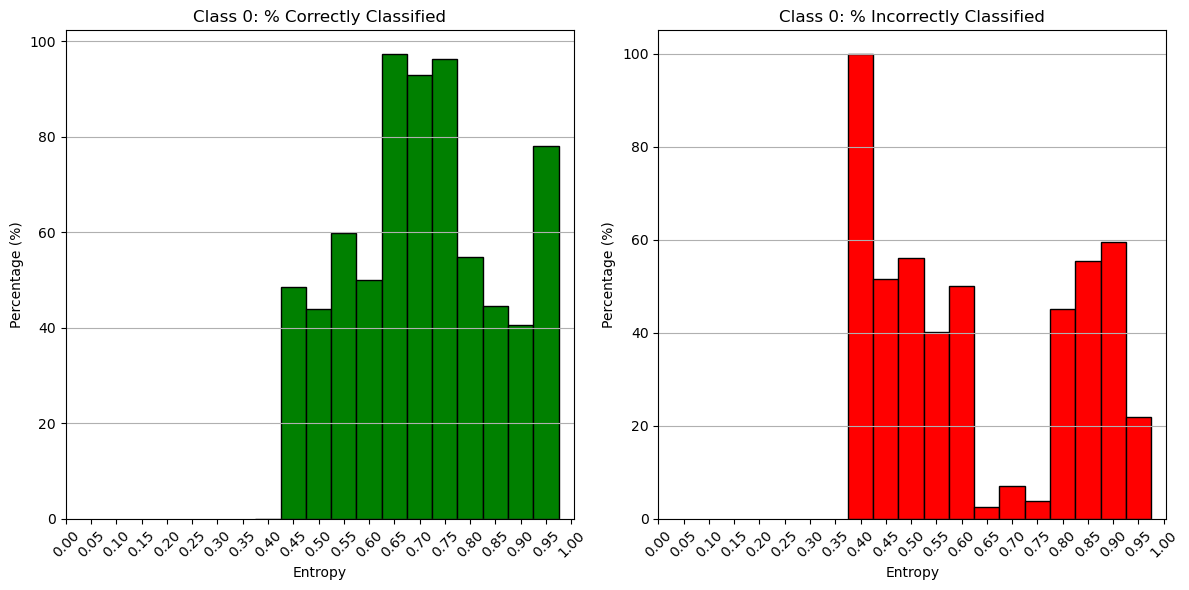

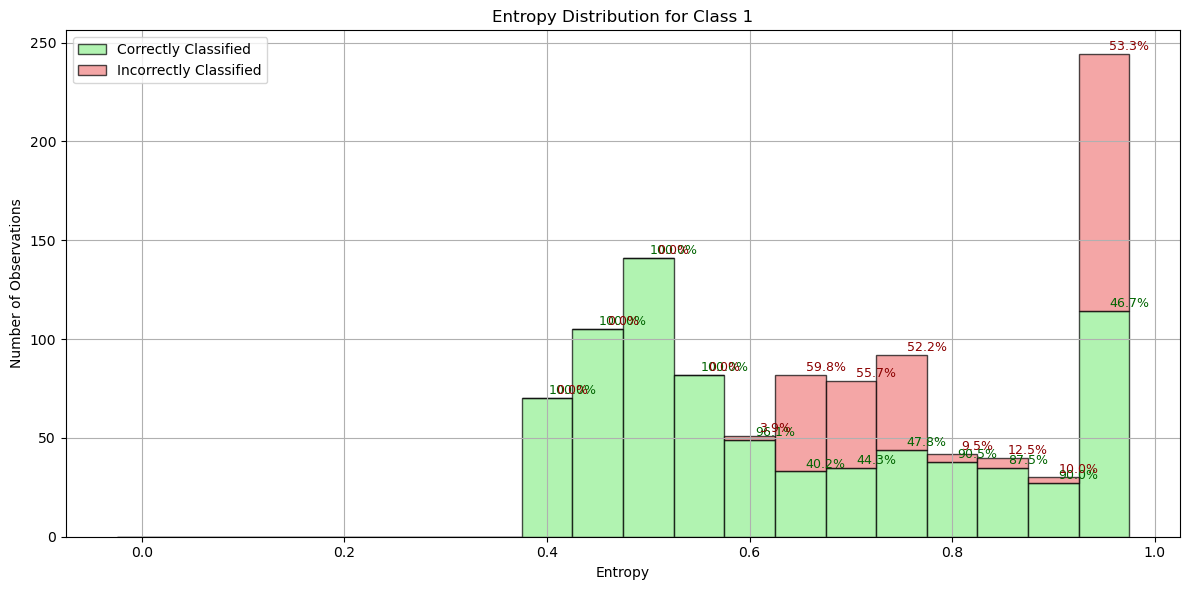

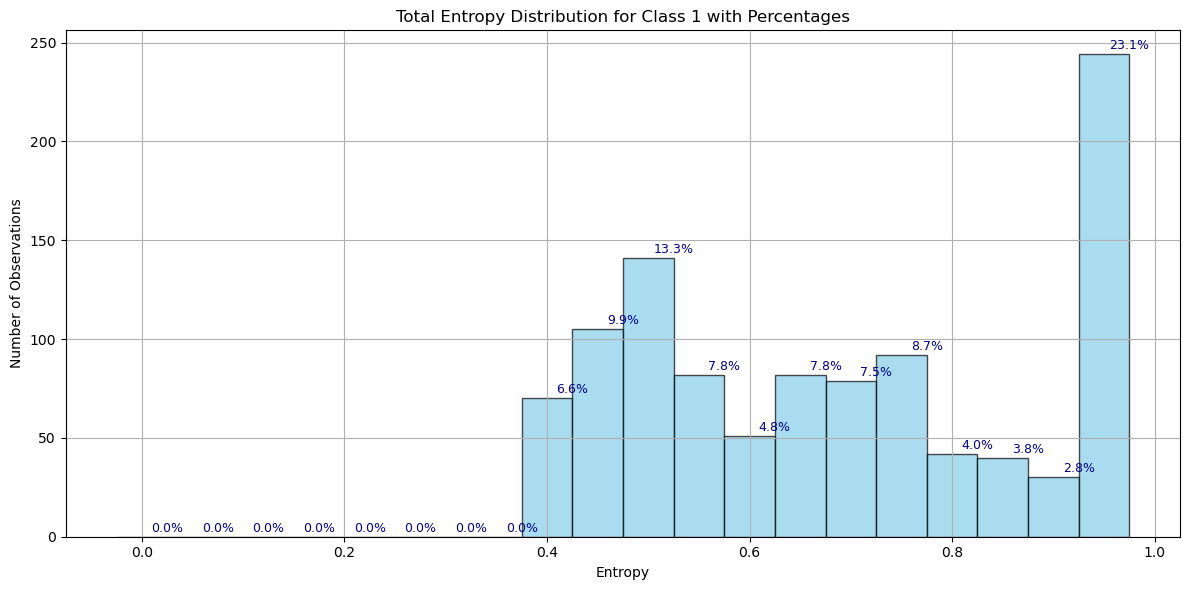

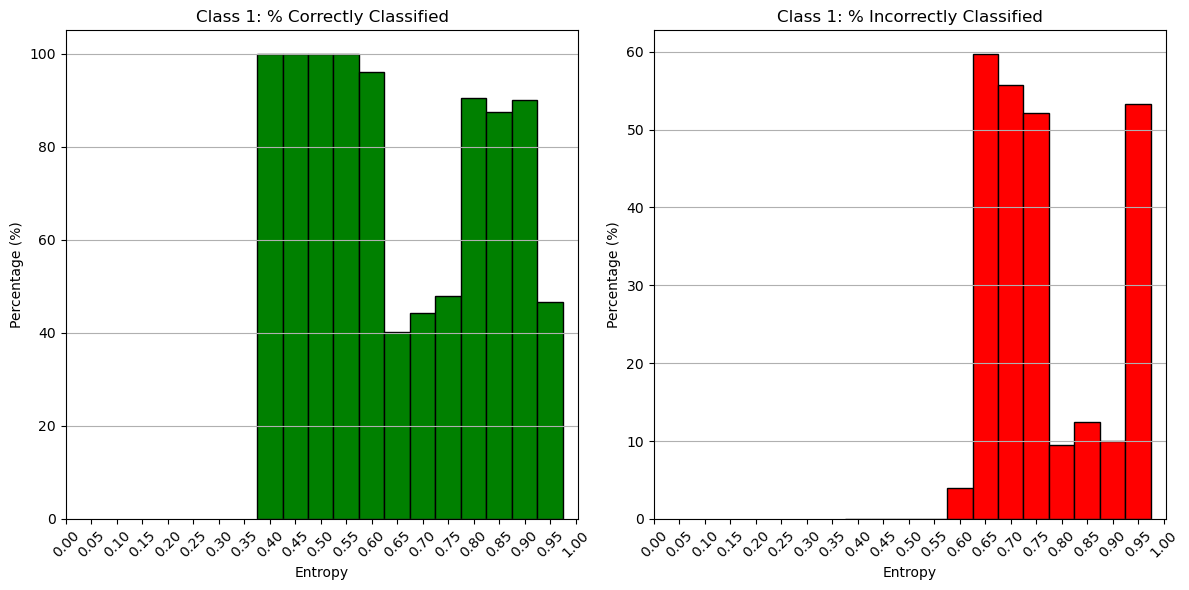

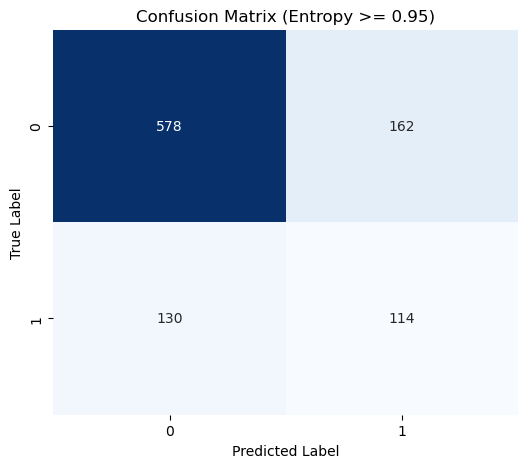

Mean entropy for the model: 0.7615
Mean entropy for correctly classified samples: 0.7493
Mean entropy for incorrectly classified samples: 0.8108
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 0 |                   0 |                    

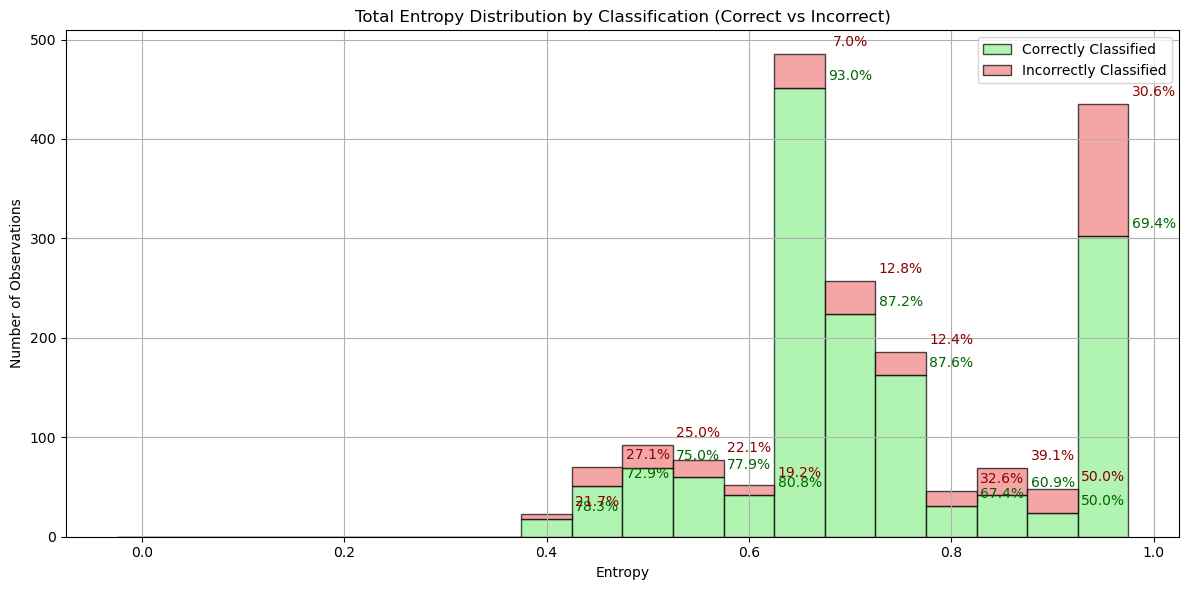

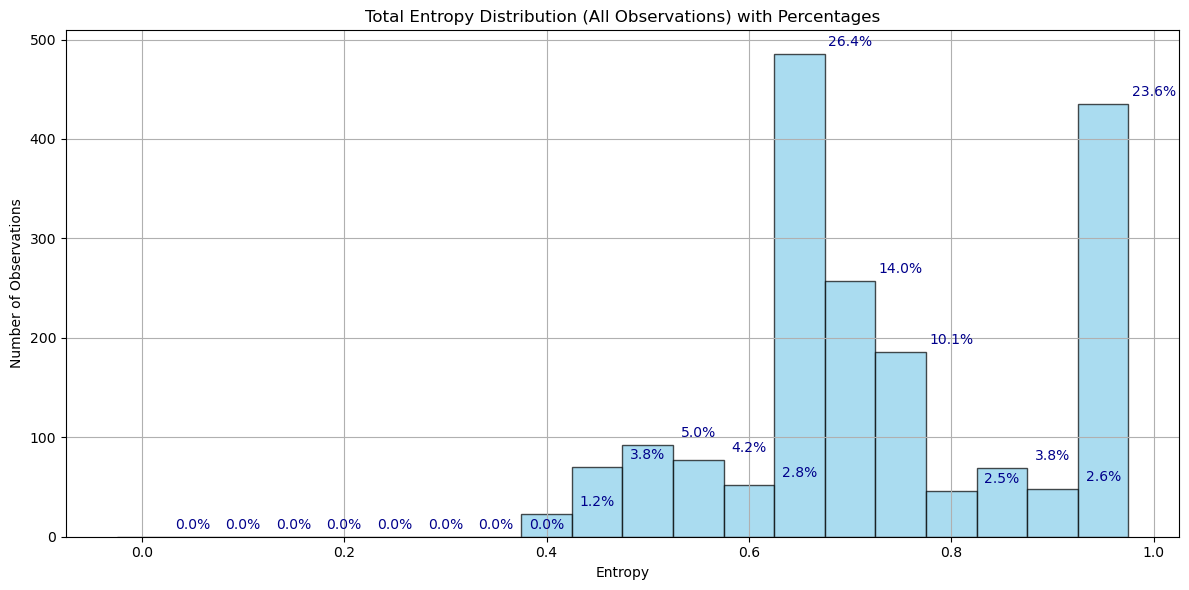

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


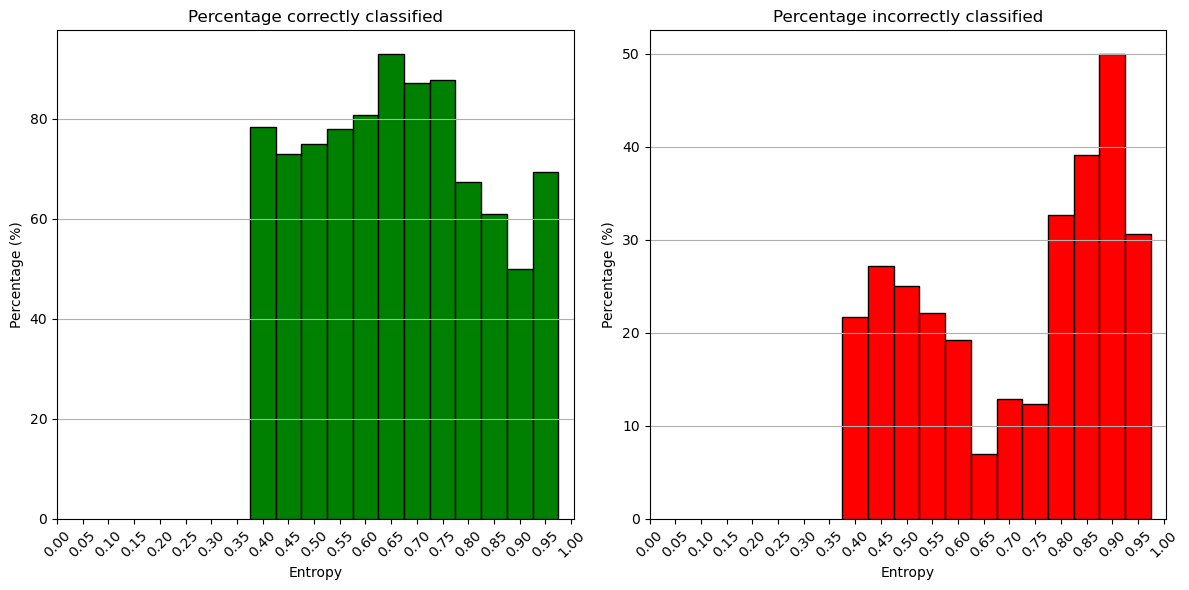

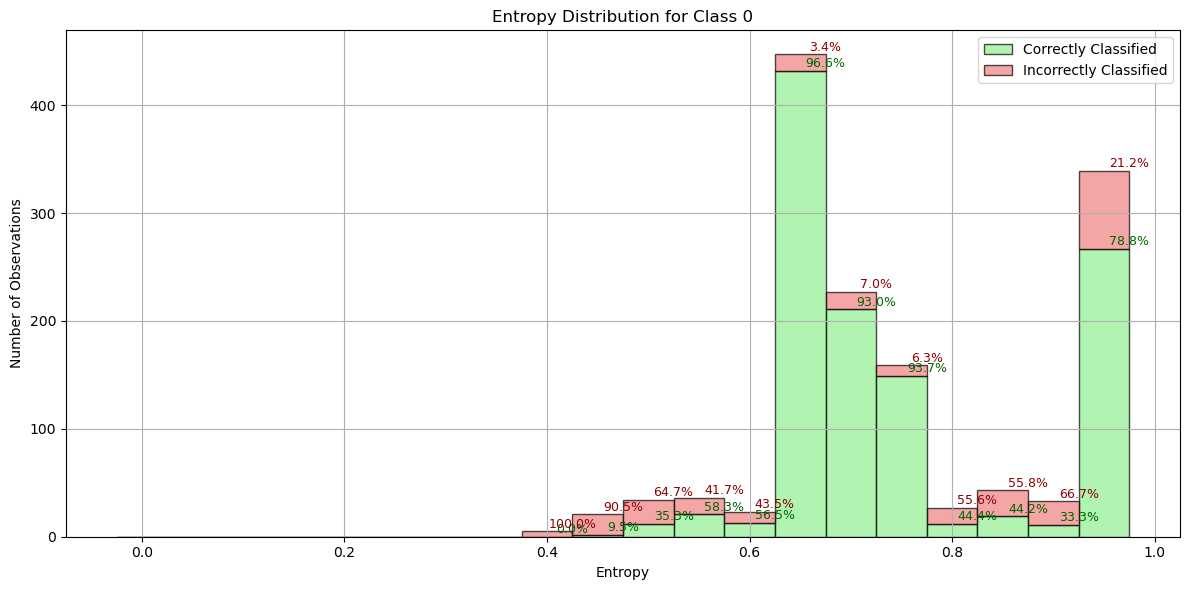

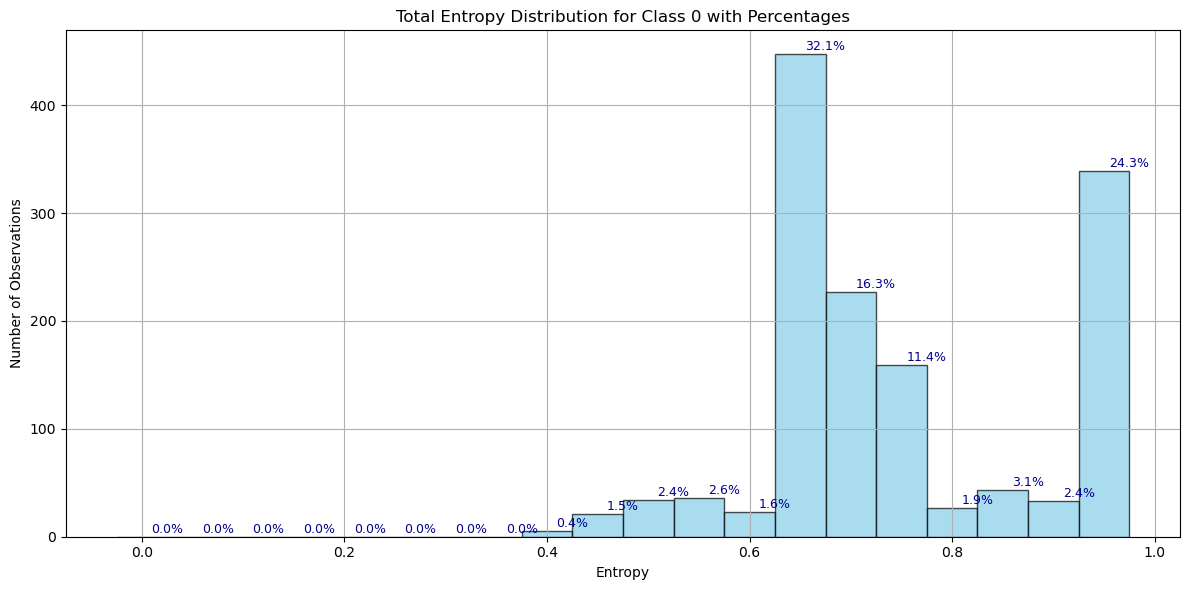

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


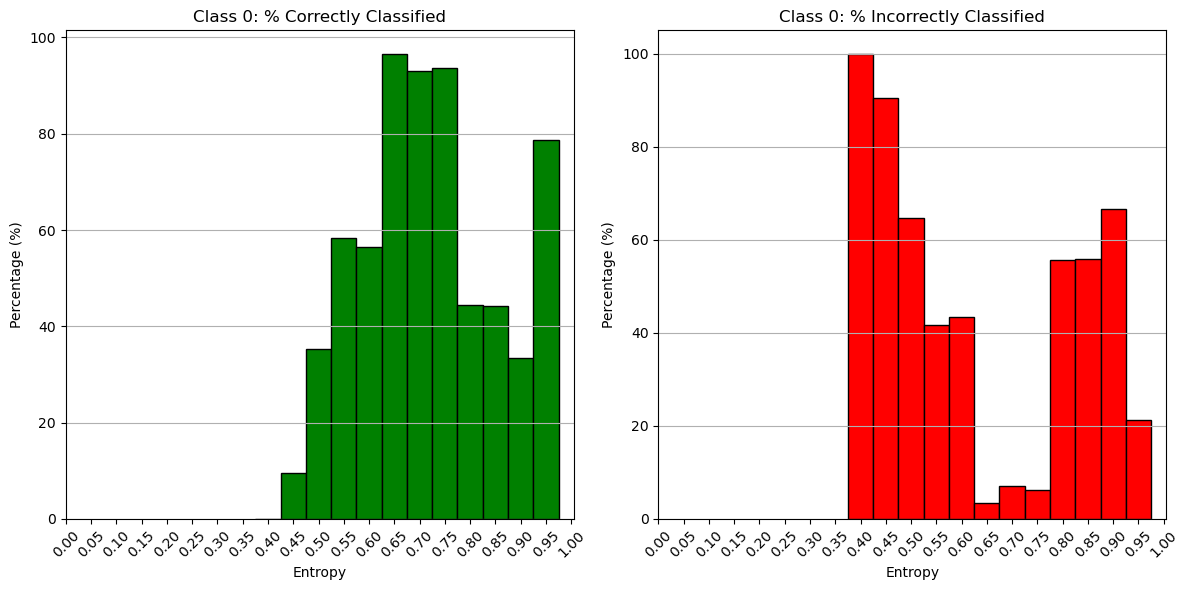

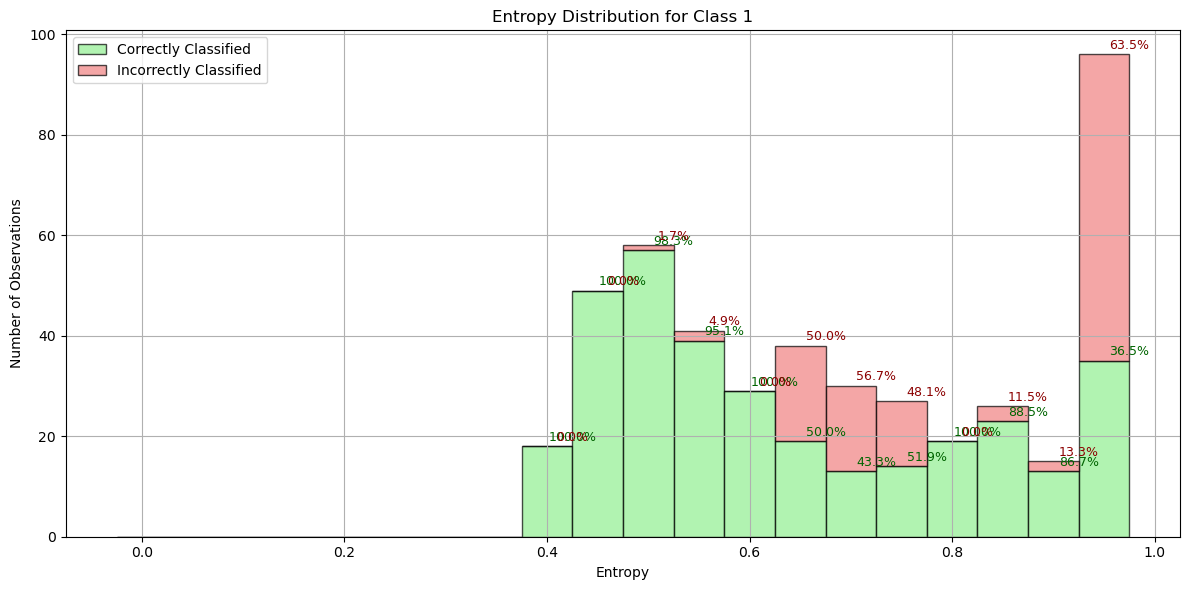

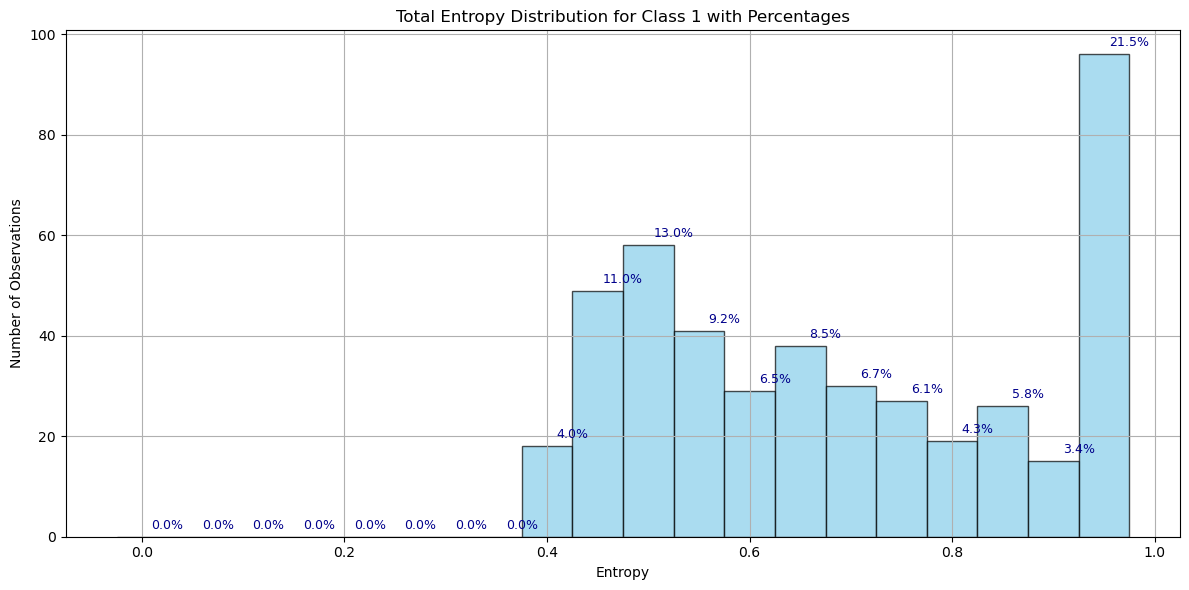

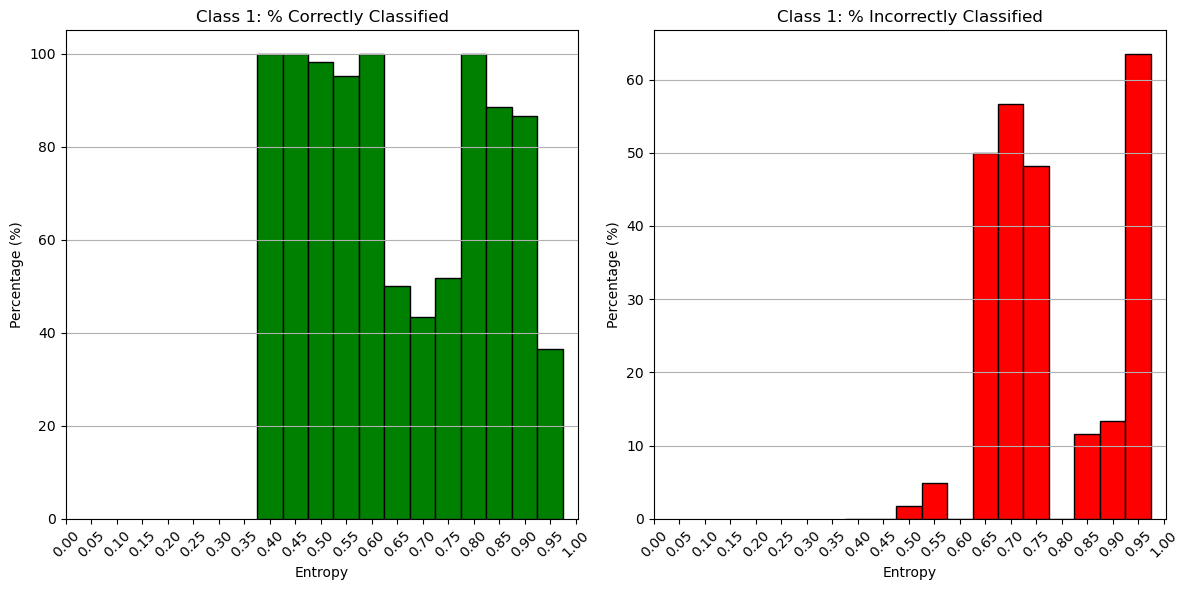

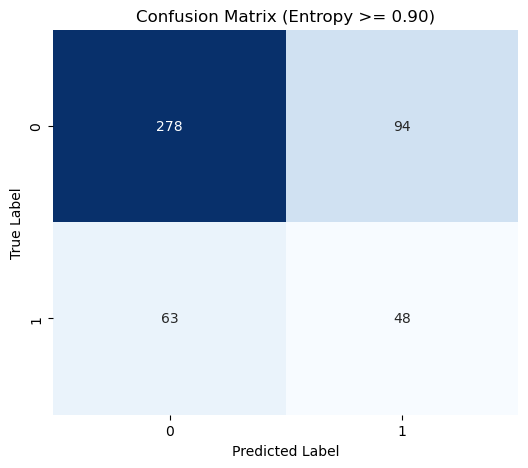

In [44]:
# Predicted probabilities over train set
probs = best_rf.predict_proba(X_train)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_train)
correct_predictions = (predictions == y_train)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_train, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.95

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_train_high_entropy = y_train.iloc[high_entropy_indices] if hasattr(y_train, "iloc") else y_train[high_entropy_indices]

cm = confusion_matrix(y_train_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()

# Predicted probabilities over test set
probs = best_rf.predict_proba(X_test)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_test)
correct_predictions = (predictions == y_test)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_test, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.9

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_test_high_entropy = y_test.iloc[high_entropy_indices] if hasattr(y_test, "iloc") else y_test[high_entropy_indices]

cm = confusion_matrix(y_test_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()

## REDUCED DATASET (DATA PROCESSING INEQUALITY)

Mean entropy for the model: 0.7478
Mean entropy for correctly classified samples: 0.7267
Mean entropy for incorrectly classified samples: 0.8341
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 0 |                   0 |                    

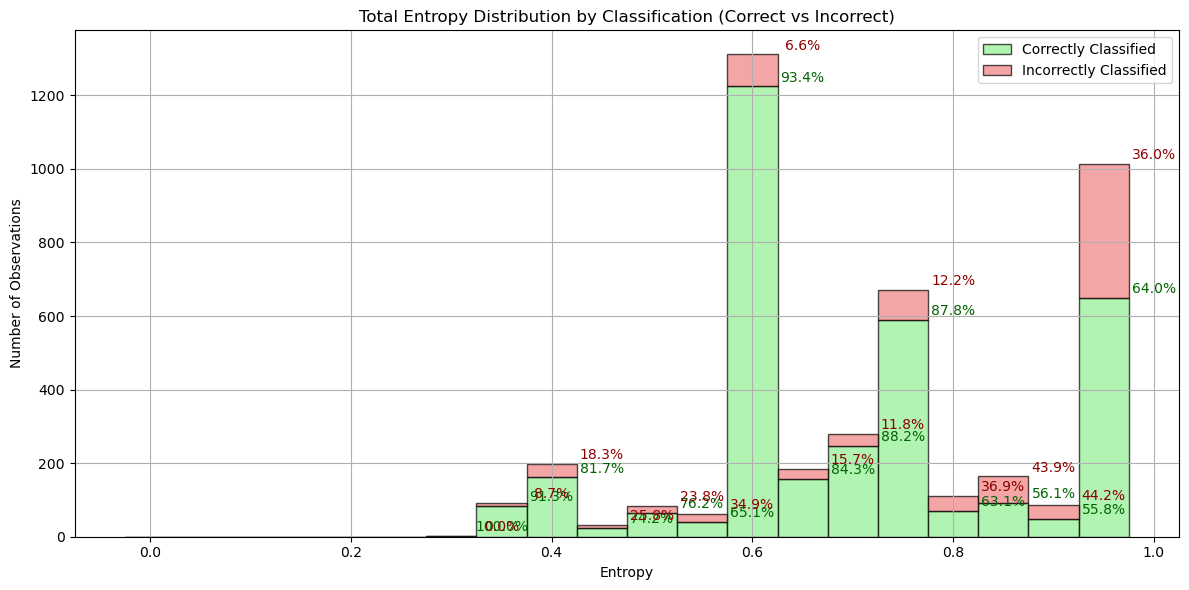

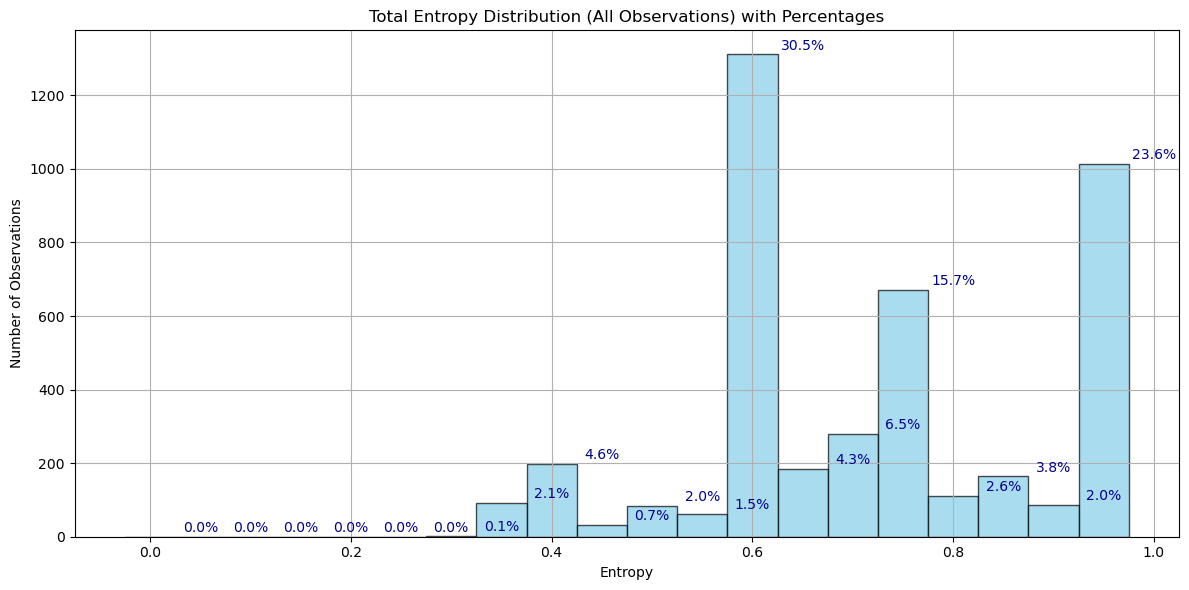

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


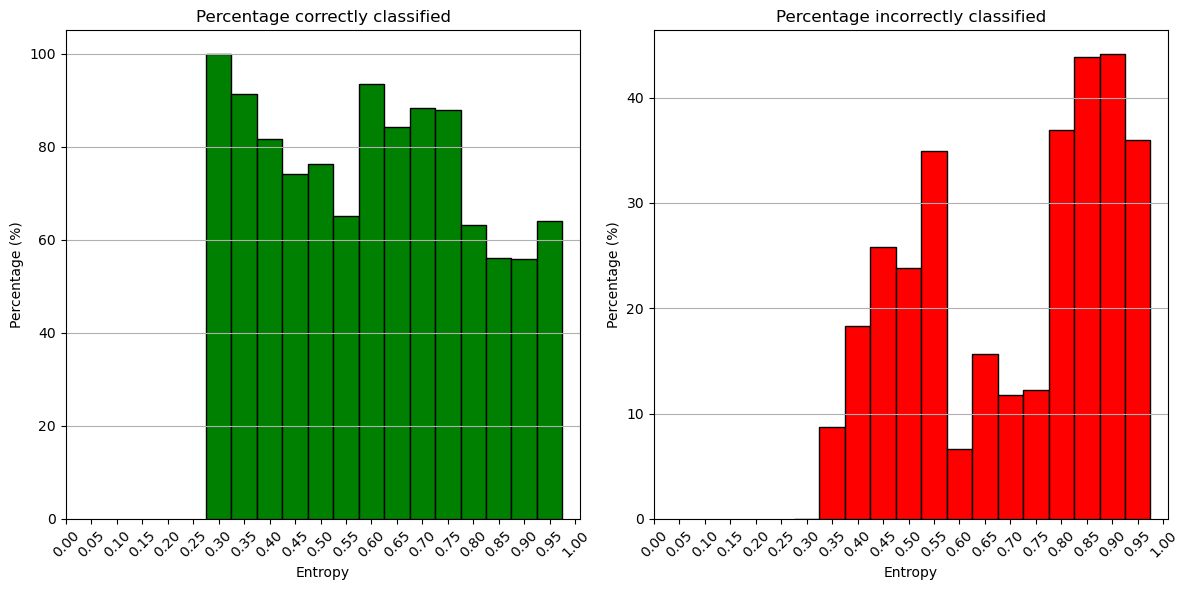

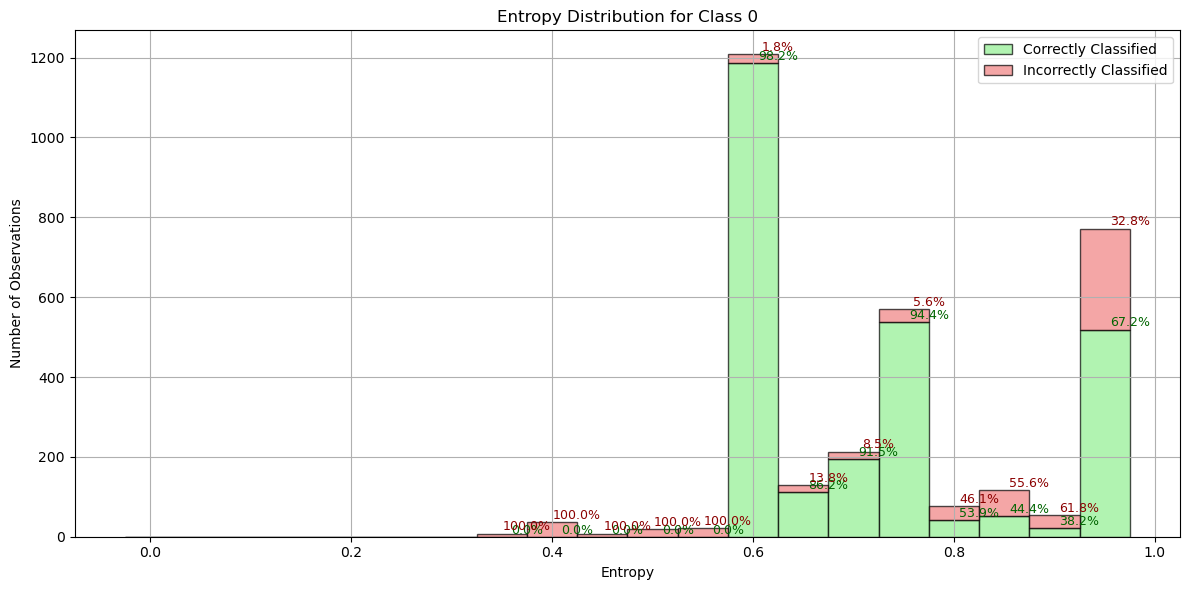

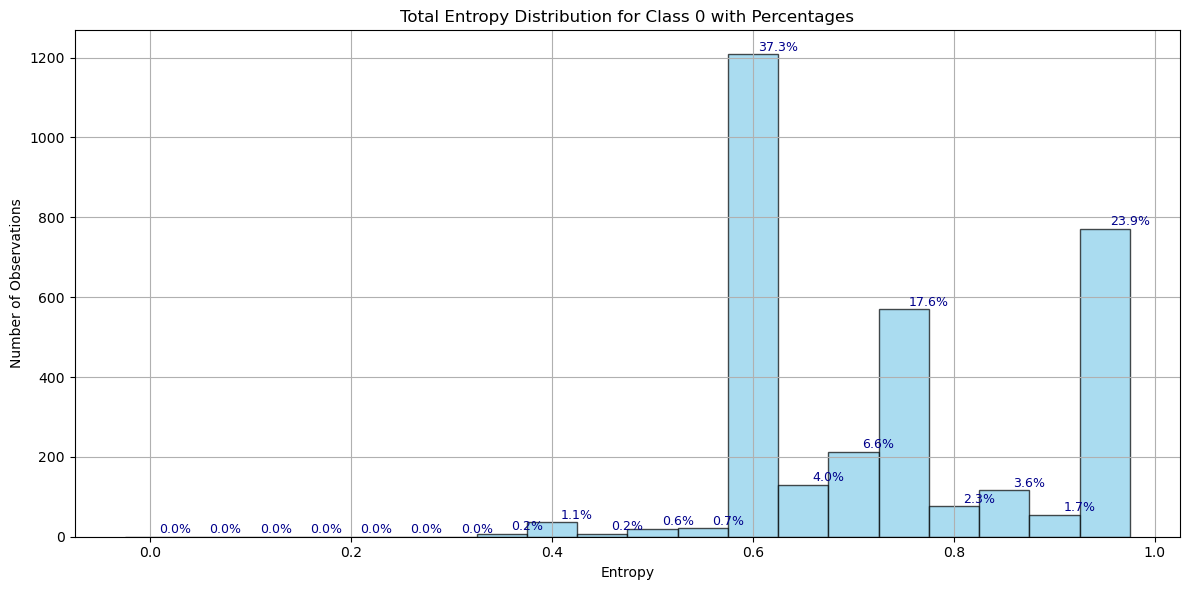

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


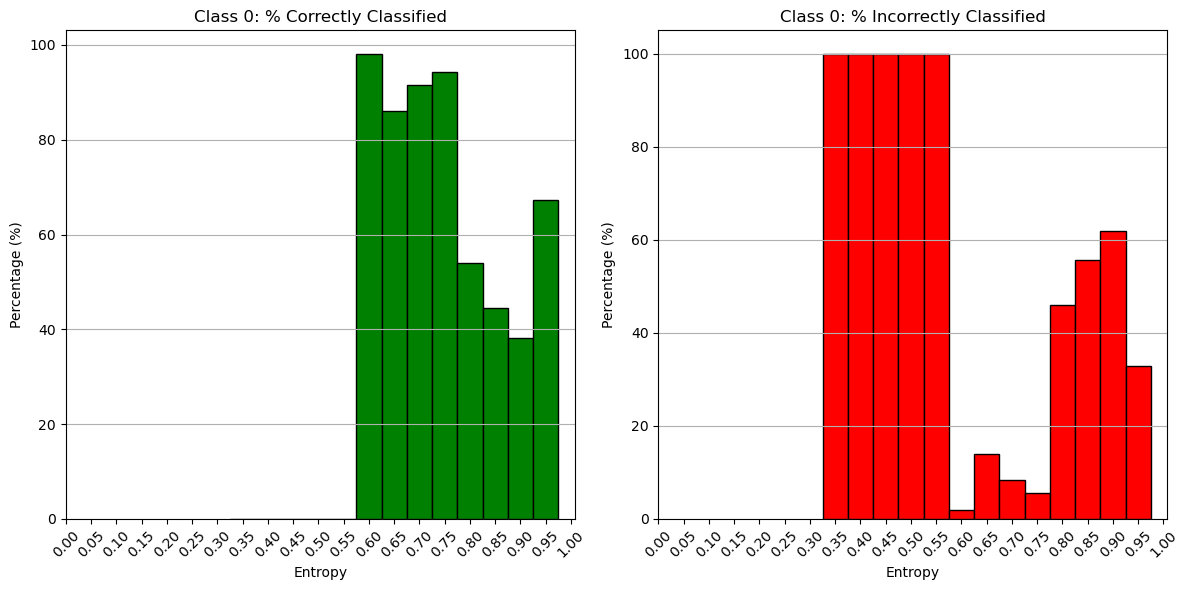

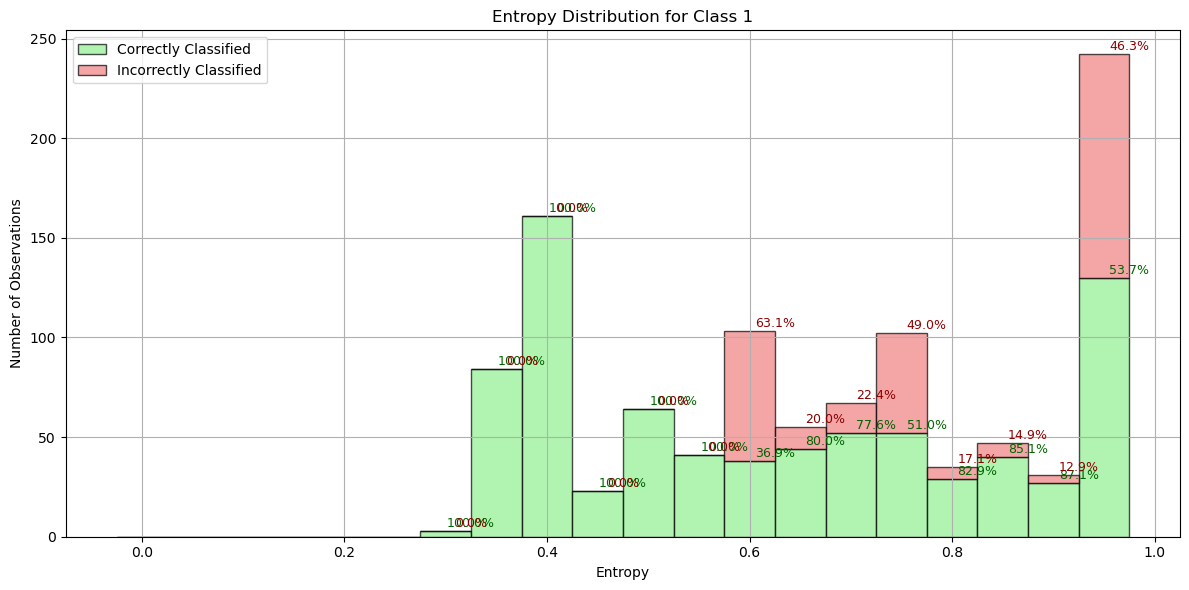

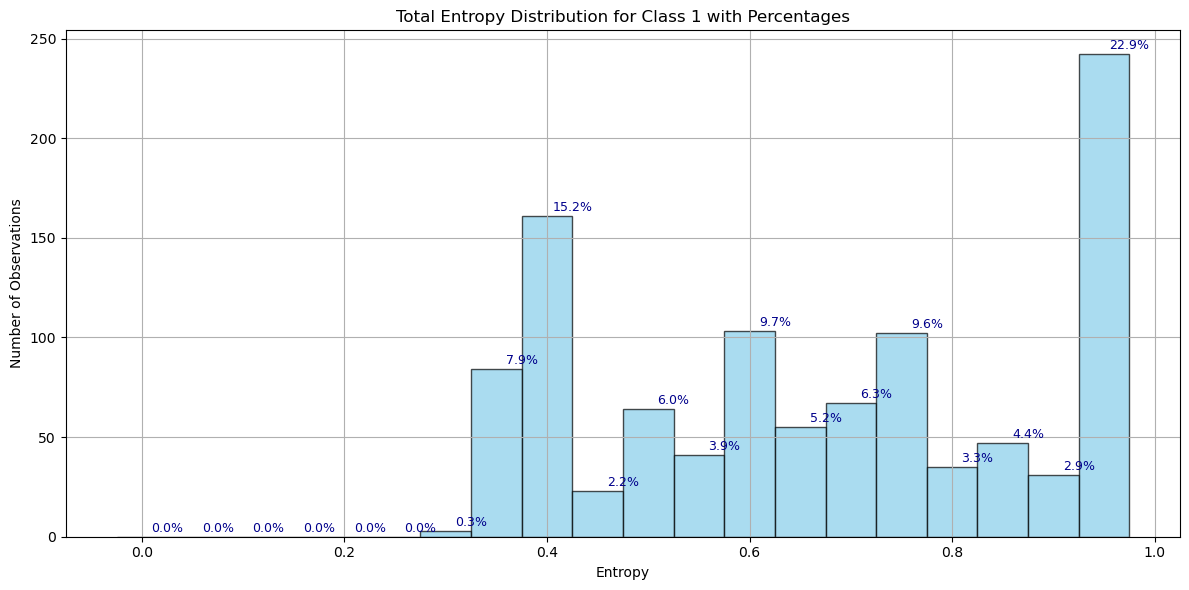

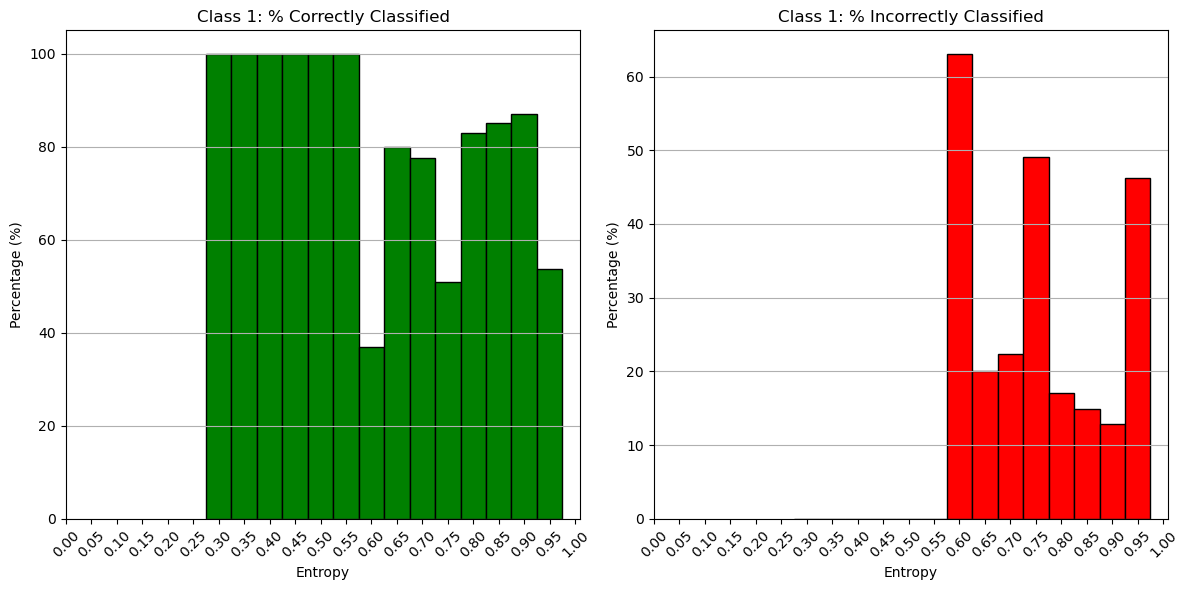

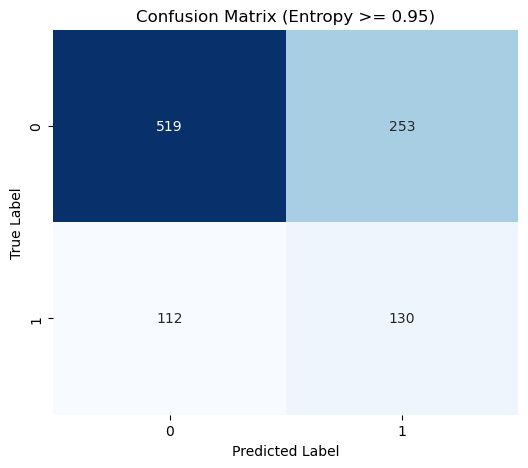

Mean entropy for the model: 0.7473
Mean entropy for correctly classified samples: 0.7271
Mean entropy for incorrectly classified samples: 0.8219
Bin Range | Total Occurrences | Correctly Classified | Incorrectly Classified | Percentage of Total | 
---------------------------------------------------------------------------------------------------
0.00 - 0.05  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.05 - 0.10  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.10 - 0.15  |                 0 |                   0 |                      0 |                 0.00%
    Correctly Classified Percentage: 0.00%
    Incorrectly Classified Percentage: 0.00%
0.15 - 0.20  |                 0 |                   0 |                    

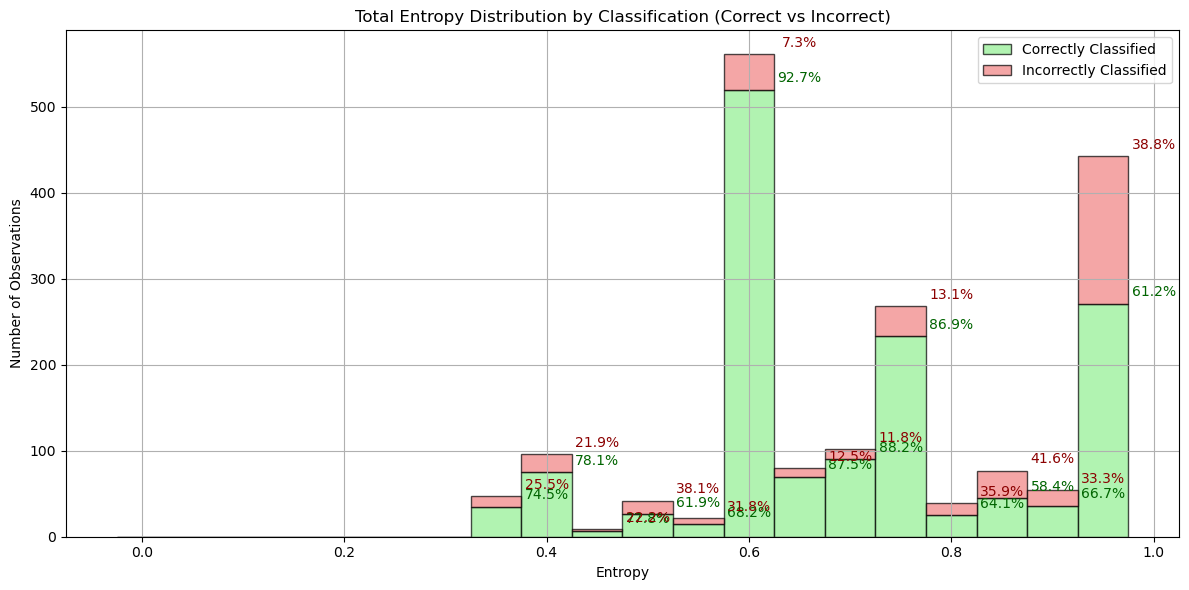

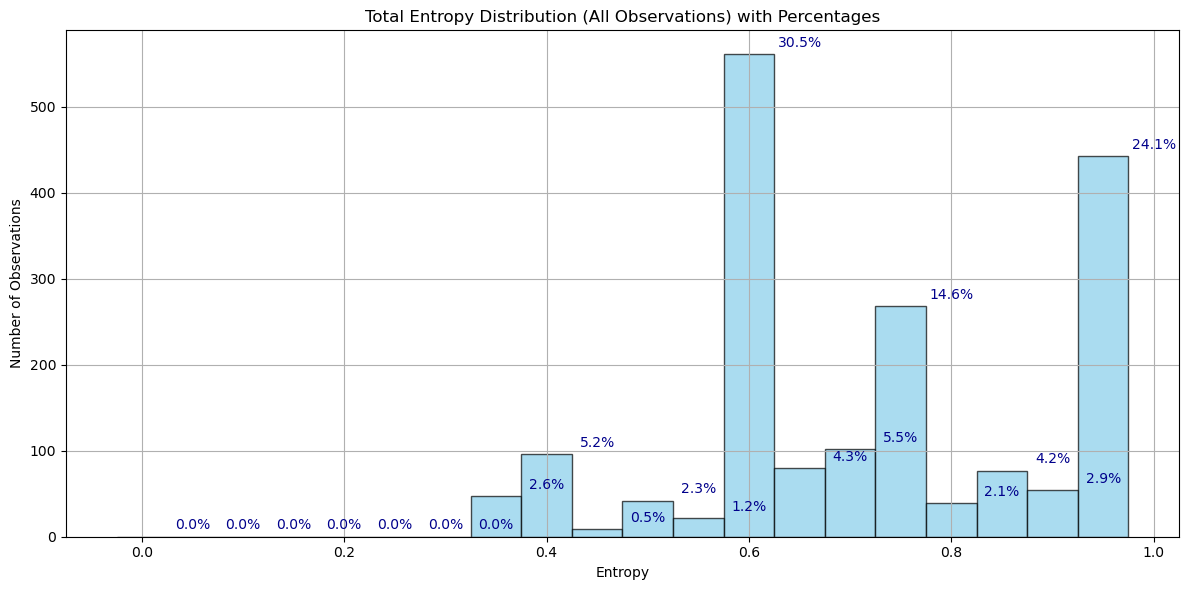

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:67: RuntimeWarning: invalid value encountered in divide
  percentage_correct = (hist_correct / total_in_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:68: RuntimeWarning: invalid value encountered in divide
  percentage_incorrect = (hist_incorrect / total_in_bin) * 100


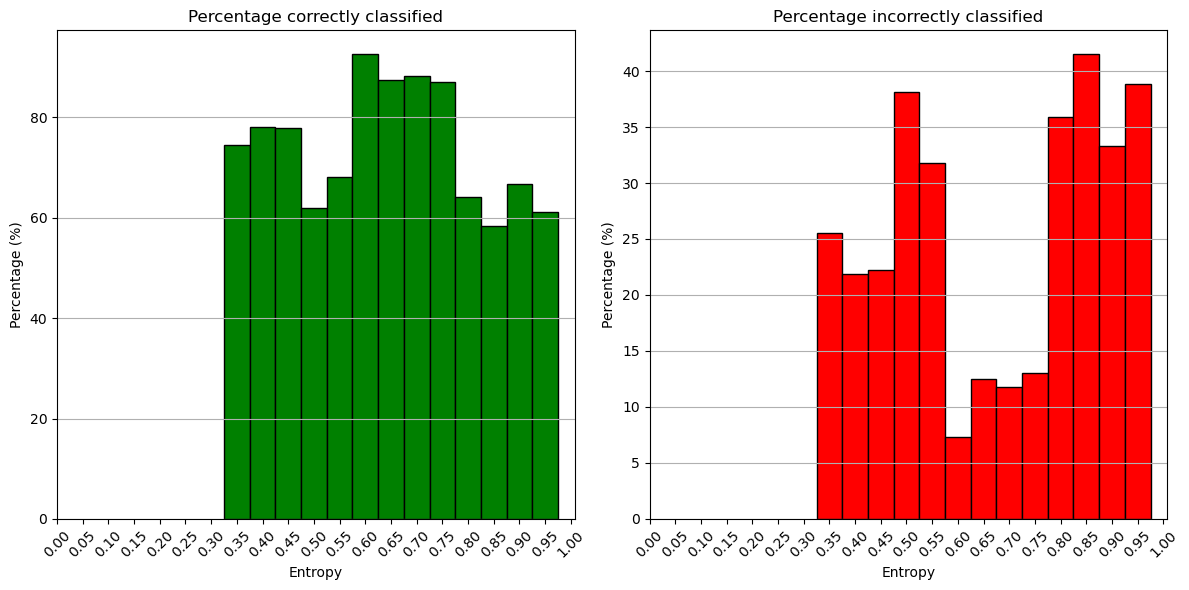

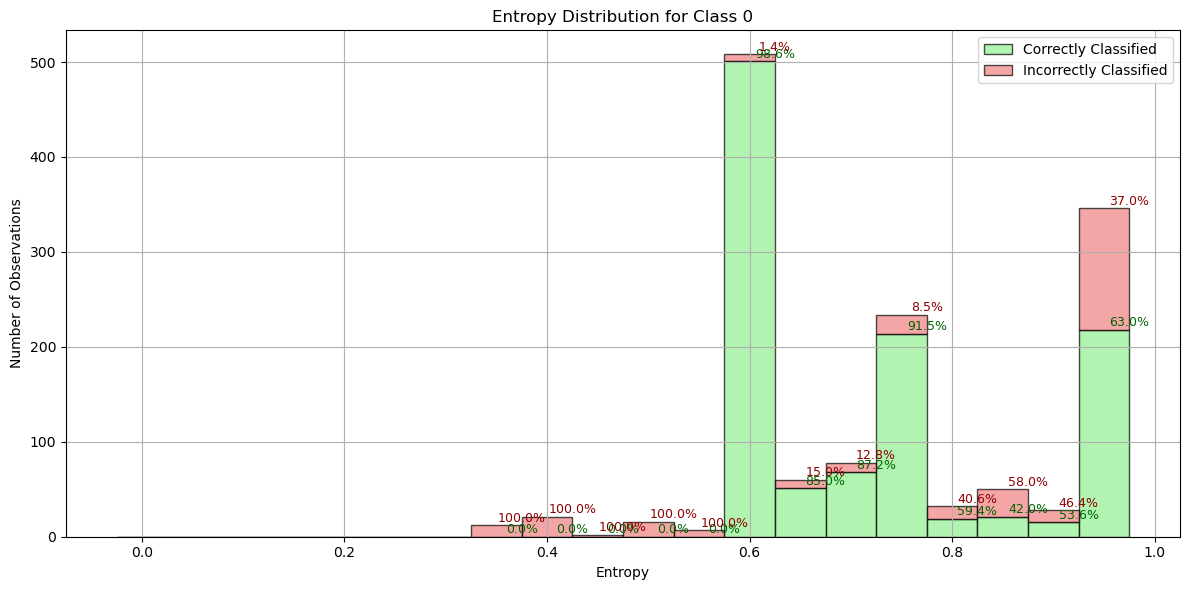

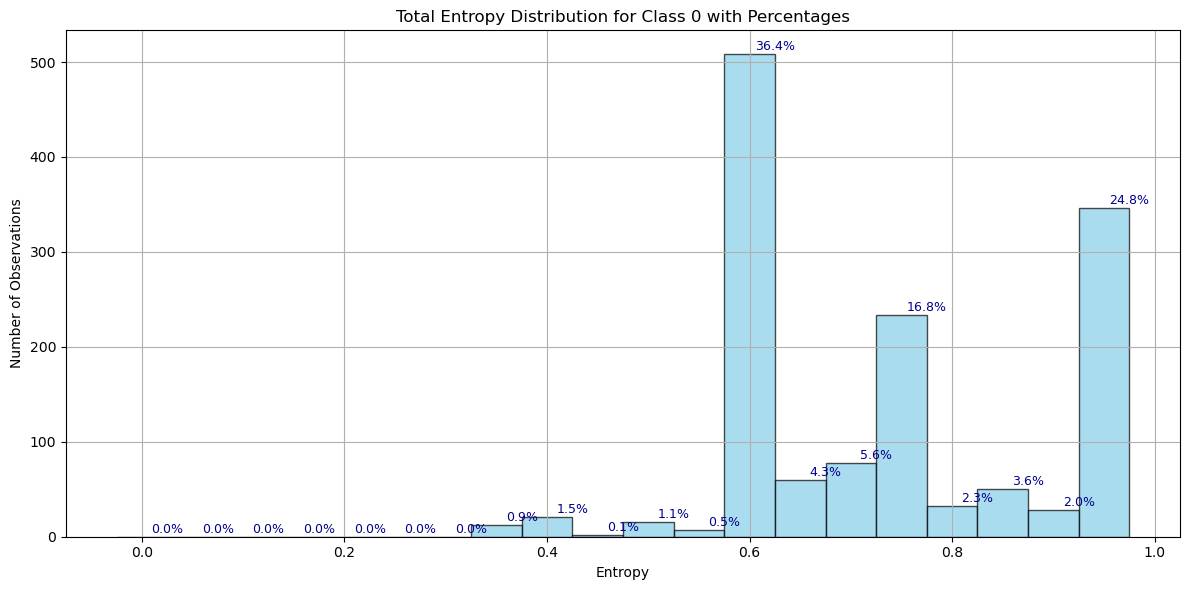

C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:152: RuntimeWarning: invalid value encountered in divide
  percent_c = (hist_c / total_bin) * 100
C:\Users\albyp\AppData\Local\Temp\ipykernel_11108\2335484974.py:153: RuntimeWarning: invalid value encountered in divide
  percent_ic = (hist_ic / total_bin) * 100


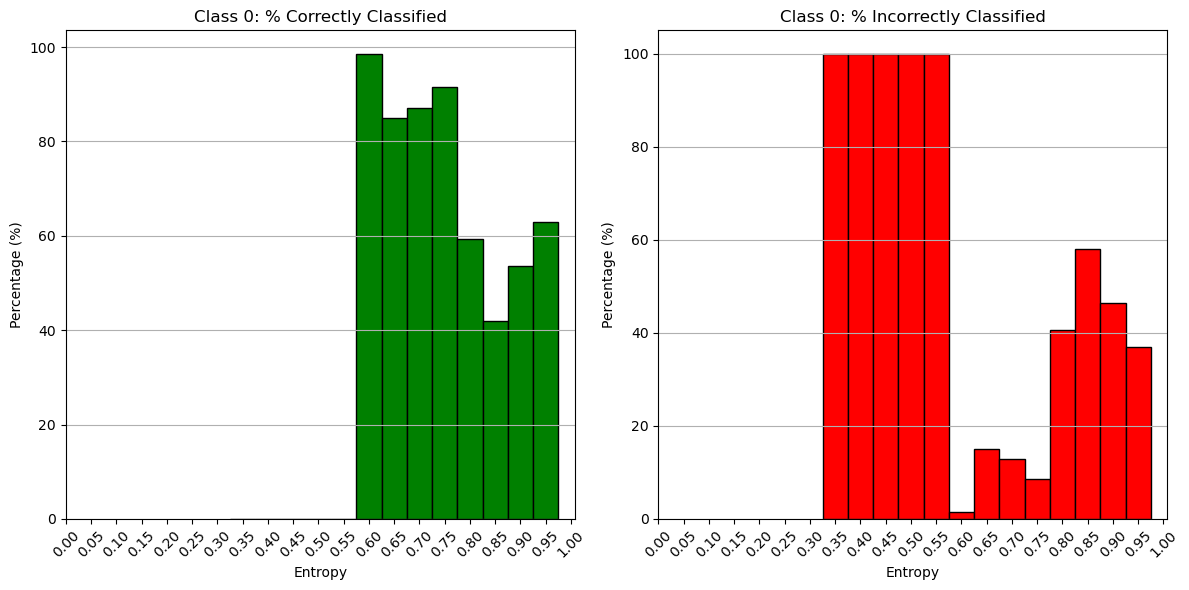

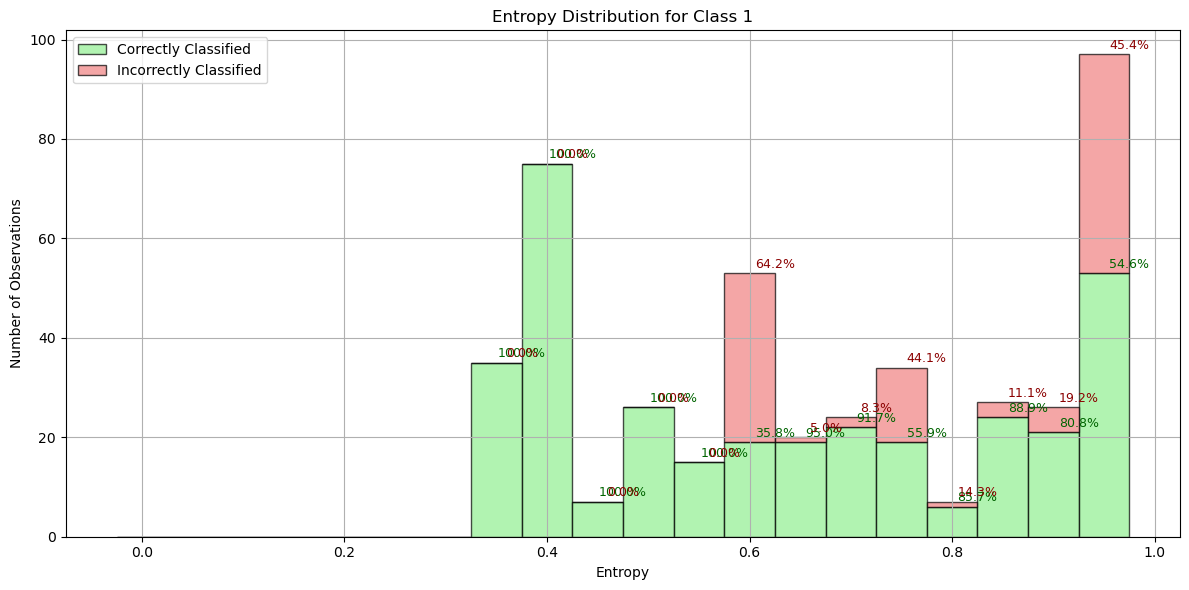

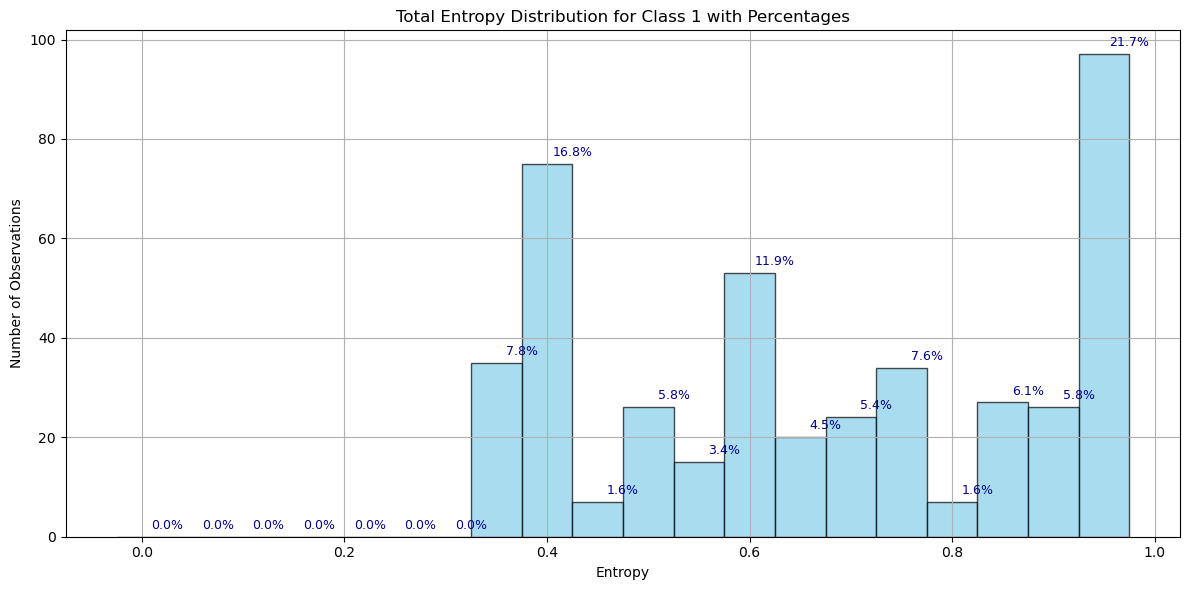

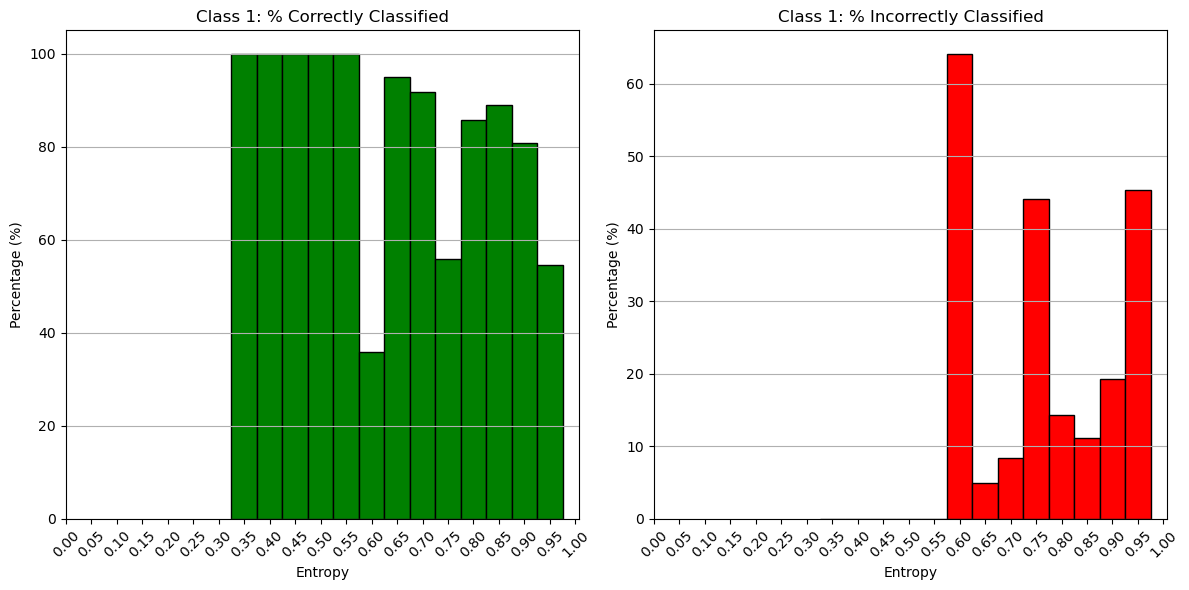

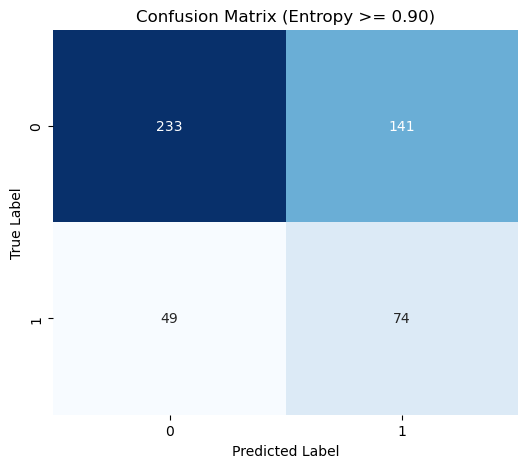

In [50]:
# Predicted probabilities over train set
probs = best_rf.predict_proba(X_train)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_train)
correct_predictions = (predictions == y_train)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_train, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.95

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_train_high_entropy = y_train.iloc[high_entropy_indices] if hasattr(y_train, "iloc") else y_train[high_entropy_indices]

cm = confusion_matrix(y_train_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()

# Predicted probabilities over test set
probs = best_rf.predict_proba(X_test)

# Entropy for each sample in test set
entropy_per_sample = -np.sum(probs * np.log2(probs + 1e-9), axis=1)

predictions = best_rf.predict(X_test)
correct_predictions = (predictions == y_test)

entropy_correct = entropy_per_sample[correct_predictions]
entropy_incorrect = entropy_per_sample[~correct_predictions]

mean_entropy_model = np.mean(entropy_per_sample)
mean_entropy_correct = np.mean(entropy_correct)
mean_entropy_incorrect = np.mean(entropy_incorrect)

print(f"Mean entropy for the model: {mean_entropy_model:.4f}")
print(f"Mean entropy for correctly classified samples: {mean_entropy_correct:.4f}")
print(f"Mean entropy for incorrectly classified samples: {mean_entropy_incorrect:.4f}")

slide = 0.05 # size of the bin
plot_entropy_total_distribution(entropy_correct, entropy_incorrect, slide, y_test=y_test, predictions=predictions, entropy_per_sample=entropy_per_sample)


threshold = 0.9

high_entropy_indices = np.where(entropy_per_sample >= threshold)[0]
predictions_high_entropy = predictions[high_entropy_indices]
y_test_high_entropy = y_test.iloc[high_entropy_indices] if hasattr(y_test, "iloc") else y_test[high_entropy_indices]

cm = confusion_matrix(y_test_high_entropy, predictions_high_entropy)

# Plot della Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Entropy >= {threshold:.2f})')
plt.show()